In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- Step 1: Define paths ---
DRIVE_CELEBA_PATH="/content/drive/MyDrive/datasets/celeba"
LOCAL_CELEBA_PATH="/content/datasets/celeba"

# --- Step 2: Create local directory ---
!mkdir -p $LOCAL_CELEBA_PATH
!echo "Local directory created at $LOCAL_CELEBA_PATH"

# --- Step 3: Copy the single ZIP file (Fast) ---
!echo "Copying image zip file from Drive..."
!cp "$DRIVE_CELEBA_PATH/img_align_celeba.zip" $LOCAL_CELEBA_PATH

# --- Step 4: Copy ALL required annotation files (Crucial Step) ---
!echo "Copying all annotation files..."
!cp "$DRIVE_CELEBA_PATH/list_attr_celeba.txt" $LOCAL_CELEBA_PATH
!cp "$DRIVE_CELEBA_PATH/list_eval_partition.txt" $LOCAL_CELEBA_PATH
!cp "$DRIVE_CELEBA_PATH/identity_CelebA.txt" $LOCAL_CELEBA_PATH
!cp "$DRIVE_CELEBA_PATH/list_bbox_celeba.txt" $LOCAL_CELEBA_PATH
!cp "$DRIVE_CELEBA_PATH/list_landmarks_align_celeba.txt" $LOCAL_CELEBA_PATH

# --- Step 5: Unzip the images locally (Fast) ---
!echo "Unzipping images..."
!unzip -q "$LOCAL_CELEBA_PATH/img_align_celeba.zip" -d $LOCAL_CELEBA_PATH
!echo "Dataset setup complete!"

Local directory created at /content/datasets/celeba
Copying image zip file from Drive...
Copying all annotation files...
Unzipping images...
Dataset setup complete!


In [ ]:
from torch.nn import init
from torch.utils.checkpoint import checkpoint
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import torch.distributions as D
import os
from torch.nn.utils.parametrizations import weight_norm
from torch.profiler import profile, record_function, ProfilerActivity, schedule
from contextlib import nullcontext # Used to conditionally disable the profiler
from torch.utils.checkpoint import checkpoint
from math import sqrt, log
from typing import List, Tuple, Dict, Any, Optional, Union
import time
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_float32_matmul_precision('high')

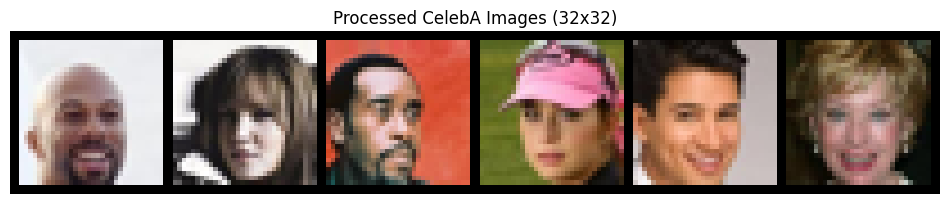

Training dataset size: 162770
Validation dataset size: 19867


In [ ]:
# For training data
train_transform = transforms.Compose([
    transforms.CenterCrop(148),
    transforms.Resize(32, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# For validation/test data (no random flipping)
test_transform = transforms.Compose([
    transforms.CenterCrop(148),
    transforms.Resize(32, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor()
])


root_dir = "/content/datasets"
train_dataset = CelebA(
    root=root_dir,
    split="train",
    transform=train_transform,
    download=False
)

val_dataset = CelebA(
    root=root_dir,
    split="valid",
    transform=test_transform,
    download=False
)

batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12)

def show_images(data_loader, num_images=6):
    dataiter = iter(data_loader)
    images, _ = next(dataiter)
    images = images[:num_images]


    img_grid = torchvision.utils.make_grid(images, nrow=num_images)
    img_grid = img_grid.permute(1, 2, 0).numpy()

    plt.figure(figsize=(12, 3))
    plt.imshow(img_grid)
    plt.title("Processed CelebA Images (32x32)")
    plt.axis('off')
    plt.show()

show_images(train_loader)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
from math import sqrt


class Swish(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(num_features))

    def forward(self, x):
        return x * torch.sigmoid(self.alpha * x)


class ResNet(nn.Module):
    def __init__(self, nres = 4, widths = [48, 512, 512, 48], final_scale = True):
        assert widths[0] == widths[-1]

        super().__init__()
        self.res_blocks = nn.ModuleList(
            [self.build_res_block(widths) for _ in range(nres)])

        if final_scale:
            self.scale = nn.Parameter(torch.zeros(widths[-1]))
        else:
            self.scale = None

    def build_linear(self, in_features, out_features):
        linear = nn.Linear(in_features, out_features)
        bound = sqrt(2.81 * 3 / in_features)
        nn.init.uniform_(linear.weight, -bound, bound)
        nn.init.zeros_(linear.bias)
        linear = weight_norm(linear)
        return linear

    def build_res_block(self, widths):
        layers = []
        for i in range(len(widths) - 1):
            layers.append(Swish(widths[i]))
            layers.append(self.build_linear(widths[i], widths[i + 1]))
        return nn.Sequential(*layers)

    def forward(self, x):
        for res_block in self.res_blocks:
            x = (x + res_block(x)) / sqrt(2)

        if self.scale is not None:
            x = x * self.scale

        return x


class ResidualNetwork(ResNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        shape = x.shape  # (B*num_RG_blocks, C, K, K)
        x = x.view(shape[0], -1)  # (B*num_RG_blocks, C*K*K)
        x = super().forward(x)
        x = x.view(shape)
        return x

In [ ]:
def create_masks(kernel_size: int, num_channels:int) -> Tuple[torch.Tensor, torch.Tensor]:
    '''
    Create checkerboard masks for the RNVP block.
    Args:
        kernel_size: The size of the kernel
        num_channels: The number of channels in the input
    Returns:
        mask: The mask for the networks
        comask: The complementary mask such that mask + comask = 1
    '''
    checkerboard = torch.from_numpy(np.indices((kernel_size, kernel_size)).sum(axis=0) % 2).float()
    mask = checkerboard.unsqueeze(0).repeat(num_channels, 1, 1)
    comask = 1 - mask
    return mask, comask

class RNVPBlock(nn.Module):
    mask: torch.Tensor
    comask: torch.Tensor

    def __init__(
        self,
        kernel_size: int,
        num_channels: int,
        s_nets: List[nn.Module],
        t_nets: List[nn.Module],
        *,
        apply_tanh: bool = True,
        use_ckpt: bool  = True,
    ):
        super().__init__()
        assert len(s_nets) == len(t_nets), "Need the same number of s and t networks"
        self.s_nets  = nn.ModuleList(s_nets)
        self.t_nets  = nn.ModuleList(t_nets)
        self.apply_tanh = apply_tanh
        self.use_ckpt   = use_ckpt

        mask, comask = create_masks(kernel_size, num_channels)
        self.register_buffer("mask",   mask)        # (C,H,W)
        self.register_buffer("comask", comask)


    def _checkpoint(self, fn, x):
        if self.training and self.use_ckpt and x.requires_grad:
            return checkpoint(fn, x, use_reentrant=False)   # saves memory
        else:
            return fn(x)

    def _one_forward_flow(
        self, x: torch.Tensor, s_net: nn.Module, t_net: nn.Module
    ) -> Tuple[torch.Tensor, torch.Tensor]:

        x1, x2 = x * self.mask, x * self.comask

        # step 1: mask -> comask
        s1 = self.comask * self._checkpoint(s_net, x1)
        t1 = self.comask * self._checkpoint(t_net, x1)
        if self.apply_tanh:  s1 = torch.tanh(s1)
        x2_ = self.comask * (torch.exp(s1) * x2 + t1)
        ldj  = s1.sum(dim=(1, 2, 3))

        # step 2: comask -> mask
        s2 = self.mask * self._checkpoint(s_net, x2_)
        t2 = self.mask * self._checkpoint(t_net, x2_)
        if self.apply_tanh:  s2 = torch.tanh(s2)
        x1_ = self.mask * (torch.exp(s2) * x1 + t2)
        ldj += s2.sum(dim=(1, 2, 3))

        return x1_ + x2_, ldj

    def _one_inverse_flow(
        self, x: torch.Tensor, s_net: nn.Module, t_net: nn.Module
    ) -> Tuple[torch.Tensor, torch.Tensor]:

        x1, x2 = x * self.mask, x * self.comask

        # step 2⁻¹
        s2 = self.mask * self._checkpoint(s_net, x2)
        t2 = self.mask * self._checkpoint(t_net, x2)
        if self.apply_tanh:  s2 = torch.tanh(s2)
        x1_ = self.mask * torch.exp(-s2) * (x1 - t2)
        ldj  = -s2.sum(dim=(1, 2, 3))

        # step 1⁻¹
        s1 = self.comask * self._checkpoint(s_net, x1_)
        t1 = self.comask * self._checkpoint(t_net, x1_)
        if self.apply_tanh:  s1 = torch.tanh(s1)
        x2_ = self.comask * torch.exp(-s1) * (x2 - t1)
        ldj -= s1.sum(dim=(1, 2, 3))

        return x1_ + x2_, ldj

    def forward(self, x):
        ldj = torch.zeros(x.size(0), device=x.device)
        for s_net, t_net in zip(self.s_nets, self.t_nets):
            x, inc = self._one_forward_flow(x, s_net, t_net)
            ldj += inc
        return x, ldj

    def inverse(self, z):
        ldj = torch.zeros(z.size(0), device=z.device)
        for s_net, t_net in zip(reversed(self.s_nets), reversed(self.t_nets)):
            z, inc = self._one_inverse_flow(z, s_net, t_net)
            ldj += inc
        return z, ldj


In [ ]:
def shift_kernel_blocks(x: torch.Tensor, m: int, h:int, inverse : bool = False) -> torch.Tensor:
    shift = (m // 2) * (2 ** h)
    if not inverse:
        return torch.roll(x, shifts=(-shift, -shift), dims=(-2, -1))
    else:
        return torch.roll(x, shifts=(shift, shift), dims=(-2, -1))

class MERABlock(nn.Module):
    def __init__(self, m, h, network, shift=False):
        super().__init__()
        self.m = m
        self.h = h
        self.network = network # Should have forward and inverse methods
        self.dilation = 2 ** h
        self.stride = m * self.dilation
        self.unfold = nn.Unfold(kernel_size=m, dilation=self.dilation, stride=self.stride)
        self.fold = None
        self.shift = shift
        self.cached_mask = None

    def _apply_flow(self, x, flow_method):
        B, C, H, W = x.shape

        x_orig = x
        x_to_process = x
        if self.shift:
            x_to_process = shift_kernel_blocks(x, self.m, self.h)

        patches = self.unfold(x_to_process)

        num_patches = patches.shape[-1]
        patches_reshaped = patches.view(B, C, self.m, self.m, num_patches).permute(0, 4, 1, 2, 3).reshape(B * num_patches, C, self.m, self.m)

        # Apply the specified flow method (forward or inverse)
        transformed_patches, ldj = flow_method(patches_reshaped)

        transformed_patches_reshaped = transformed_patches.view(B, num_patches, C, self.m, self.m).permute(0, 2, 3, 4, 1).reshape(B, C * self.m * self.m, num_patches)

        if self.fold is None:
            self.fold = nn.Fold(output_size=(H, W), kernel_size=self.m, dilation=self.dilation, stride=self.stride)
            with torch.no_grad():
                single_item_patches = patches.narrow(0, 0, 1)
                self.cached_mask = self.fold(torch.ones_like(single_item_patches))

        folded = self.fold(transformed_patches_reshaped)

        mask = self.cached_mask.expand(B, C, H, W)

        if self.shift:
            folded = shift_kernel_blocks(folded, self.m, self.h, inverse=True)
            mask = shift_kernel_blocks(mask, self.m, self.h, inverse=True)

        x_updated = torch.where(mask.bool(), folded, x_orig)

        return x_updated, ldj.view(B, -1).sum(dim=1)

    def forward(self, x):
        return self._apply_flow(x, self.network.forward)

    def inverse(self, x):
        return self._apply_flow(x, self.network.inverse)

class RG_Flow(nn.Module):
    """A full MERA model built from a sequence of MERABlock layers."""
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        ldj = torch.zeros(x.shape[0], device=x.device)
        for layer in self.layers:
            x, ldj_ = layer.forward(x)
            ldj += ldj_
        return x, ldj

    def inverse(self, x):
        ldj = torch.zeros(x.shape[0], device=x.device)
        for layer in reversed(self.layers):
            x, ldj_ = layer.inverse(x)
            ldj += ldj_
        return x, ldj

In [ ]:
class PriorDistribution(nn.Module):
    def __init__(self, dist_type='laplace'):
        super().__init__()
        if dist_type == 'laplace':
            self.base_dist = D.Laplace
        elif dist_type == 'gaussian':
            self.base_dist = D.Normal
        else:
            raise ValueError(f"Unsupported distribution type: {dist_type}")

    def __repr__(self):
        return f"PriorDistribution(dist_type={self.base_dist.__name__})"

    def log_prob(self, z, temperature=1.0):
        dist = self.base_dist(loc=torch.zeros_like(z), scale=torch.ones_like(z) * temperature)
        return dist.log_prob(z).sum(dim=[1, 2, 3]) # Sum over all dimensions except batch

    def sample(self, shape, temperature=1.0):
        dist = self.base_dist(loc=torch.zeros(shape), scale=torch.ones(shape) * temperature)
        return dist.sample()

In [ ]:
n_layers = [8, 8, 6, 6, 4, 4, 2, 2]

layers = []
for n in n_layers:
    s_nets = [ResidualNetwork() for _ in range(n)]
    t_nets = [ResidualNetwork() for _ in range(n)]
    layers.append(RNVPBlock(kernel_size=4, num_channels=3, s_nets=s_nets, t_nets=t_nets, apply_tanh=True, use_ckpt=True))

MERA_layers = []
for i, layer in enumerate(layers):
    MERA_layers.append(
        MERABlock(m=4, h = i // 2, network=layer, shift=(i % 2 == 1))
    )
flow = RG_Flow(MERA_layers)
flow.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


RG_Flow(
  (layers): ModuleList(
    (0-1): 2 x MERABlock(
      (network): RNVPBlock(
        (s_nets): ModuleList(
          (0-7): 8 x ResidualNetwork(
            (res_blocks): ModuleList(
              (0-3): 4 x Sequential(
                (0): Swish()
                (1): Linear(in_features=48, out_features=512, bias=True)
                (2): Swish()
                (3): Linear(in_features=512, out_features=512, bias=True)
                (4): Swish()
                (5): Linear(in_features=512, out_features=48, bias=True)
              )
            )
          )
        )
        (t_nets): ModuleList(
          (0-7): 8 x ResidualNetwork(
            (res_blocks): ModuleList(
              (0-3): 4 x Sequential(
                (0): Swish()
                (1): Linear(in_features=48, out_features=512, bias=True)
                (2): Swish()
                (3): Linear(in_features=512, out_features=512, bias=True)
                (4): Swish()
                (5): Linear(in_fea

In [ ]:
def logit_transform(x, dequant=True, constraint=0.9, inverse=False):
    if inverse:
        logit_x = x
        pre_logit_scale = torch.tensor(log(constraint) - log(1 - constraint))
        ldj = (F.softplus(logit_x) + F.softplus(-logit_x) -
               F.softplus(-pre_logit_scale))
        ldj = ldj.view(ldj.shape[0], -1).sum(dim=1)
        x = 1 / (1 + torch.exp(-logit_x))
        x *= 2
        x -= 1
        x /= constraint
        x += 1
        x /= 2

        return x, ldj

    else:
        if dequant:
            noise = torch.rand_like(x)
            x = (x * 255 + noise) / 256
        x *= 2
        x -= 1
        x *= constraint
        x += 1
        x /= 2
        logit_x = torch.log(x) - torch.log(1 - x)
        pre_logit_scale = torch.tensor(log(constraint) - log(1 - constraint))
        ldj = (F.softplus(logit_x) + F.softplus(-logit_x) - F.softplus(-pre_logit_scale))
        ldj = ldj.view(ldj.shape[0], -1).sum(dim=1)
        return logit_x, ldj

In [ ]:
def generate_and_show_images(
    model: RG_Flow,
    prior: PriorDistribution,
    epoch: int,
    num_images: int,
    image_dims: tuple,
    device: str,
    save_dir: str = "generated_images"
):
    """
    Generates images from the model, displays them, and saves them to a file.

    Args:
        model: The RG_Flow model instance.
        prior: The prior distribution.
        epoch: The current epoch number (for titling and saving).
        num_images: The number of images to generate.
        image_dims: A tuple of (channels, height, width).
        device: The device to run generation on.
        save_dir: Directory to save the generated images.
    """
    model.eval()

    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        n_channels, height, width = image_dims
        z_shape = (num_images, n_channels, height, width)
        z = prior.sample(z_shape).to(device)
        generated_logits, _ = model.inverse(z)
        generated_images, _ = logit_transform(generated_logits, dequant=False, inverse=True)
        generated_images = generated_images.cpu()
        generated_images = torch.clamp(generated_images, 0, 1)
    grid = torchvision.utils.make_grid(generated_images, nrow=int(sqrt(num_images)))
    img_grid = grid.permute(1, 2, 0).numpy()

    plt.figure(figsize=(8, 8))
    plt.imshow(img_grid)
    plt.title(f"Generated Images at Epoch {epoch + 1}")
    plt.axis('off')
    plt.savefig(os.path.join(save_dir, f"epoch_{epoch+1:03d}.png"))
    plt.show()

    model.train()

In [ ]:
import logging
import time
from datetime import datetime

def setup_logger(name='rg_flow_training'):
    # Create a logger
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO) # Set the minimum level of messages to log

    # Prevent the logger from propagating to the root logger
    logger.propagate = False

    # Create a formatter
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s',
                                  datefmt='%Y-%m-%d %H:%M:%S')

    # --- File Handler ---
    # Create a unique log file name with a timestamp
    log_filename = f"training_run_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.log"
    file_handler = logging.FileHandler(log_filename)
    file_handler.setFormatter(formatter)

    # --- Console Handler ---
    stream_handler = logging.StreamHandler() # Writes to console
    stream_handler.setFormatter(formatter)

    # Add handlers to the logger, but only if they haven't been added before
    if not logger.handlers:
        logger.addHandler(file_handler)
        logger.addHandler(stream_handler)

    return logger

In [ ]:
def train_rg_flow(
    model: RG_Flow,
    prior: PriorDistribution,
    train_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    num_epochs: int,
    device: str,
    image_dims: tuple,
    logger: logging.Logger,
    num_images_to_generate: int = 16
):
    """
    The main training loop for the RG-Flow model.
    ... (args documentation) ...
    Args:
        logger: A configured logger object.
    """
    model.train()
    model.to(device)
    prior.to(device)

    n_channels, height, width = image_dims
    bpd_factor = np.log(2) * n_channels * height * width
    logger.info(f"Training for {num_epochs} epochs...")
    logger.info(f"Batch size: {BATCH_SIZE}")
    logger.info(f"Learning rate: {LEARNING_RATE}")
    logger.info(f"Image dimensions: {image_dims}")
    logger.info(f"Number of images to generate: {num_images_to_generate}")
    logger.info(prior)

    logger.info("--- Starting Training ---")
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        total_loss = 0.0

        for batch_idx, (x, _) in enumerate(train_loader):
            optimizer.zero_grad()
            x = x.to(device)
            x, ldj_logit = logit_transform(x)
            z_final, ldj_combined = model.forward(x)
            logp_prior = prior.log_prob(z_final)
            total_log_likelihood = logp_prior + ldj_combined + ldj_logit
            loss = -torch.mean(total_log_likelihood)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            total_loss += loss.item()

            if batch_idx % 50 == 0: # Log less frequently for a cleaner file
                bpd = (loss.item() + np.log(256.) * (n_channels * height * width)) / bpd_factor
                logger.info(f"Epoch: {epoch+1}/{num_epochs} | Batch: {batch_idx}/{len(train_loader)} | Loss (NLL): {loss.item():.4f} | BPD: {bpd:.4f}")

        avg_loss = total_loss / len(train_loader)
        epoch_time = time.time() - epoch_start_time
        logger.info(f"--- Epoch {epoch+1} Summary ---")
        logger.info(f"Average Loss: {avg_loss:.4f} | Time: {epoch_time:.2f}s")

        logger.info("Generating sample images...")
        generate_and_show_images(
            model=model,
            prior=prior,
            epoch=epoch,
            num_images=num_images_to_generate,
            image_dims=image_dims,
            device=device
        )

        logger.info("-" * 30)

2025-06-21 22:56:37 - INFO - Training for 60 epochs...
2025-06-21 22:56:37 - INFO - Batch size: 512
2025-06-21 22:56:37 - INFO - Learning rate: 0.001
2025-06-21 22:56:37 - INFO - Image dimensions: (3, 32, 32)
2025-06-21 22:56:37 - INFO - Number of images to generate: 16
2025-06-21 22:56:37 - INFO - PriorDistribution(dist_type=Normal)
2025-06-21 22:56:37 - INFO - --- Starting Training ---
2025-06-21 22:56:43 - INFO - Epoch: 1/60 | Batch: 0/318 | Loss (NLL): 460.7857 | BPD: 8.2164
2025-06-21 22:59:04 - INFO - Epoch: 1/60 | Batch: 50/318 | Loss (NLL): -3958.0391 | BPD: 6.1412
2025-06-21 23:01:25 - INFO - Epoch: 1/60 | Batch: 100/318 | Loss (NLL): -5222.2295 | BPD: 5.5475
2025-06-21 23:03:46 - INFO - Epoch: 1/60 | Batch: 150/318 | Loss (NLL): -5773.4072 | BPD: 5.2887
2025-06-21 23:06:06 - INFO - Epoch: 1/60 | Batch: 200/318 | Loss (NLL): -6105.6963 | BPD: 5.1326
2025-06-21 23:08:27 - INFO - Epoch: 1/60 | Batch: 250/318 | Loss (NLL): -6533.1992 | BPD: 4.9318
2025-06-21 23:10:48 - INFO - Epo

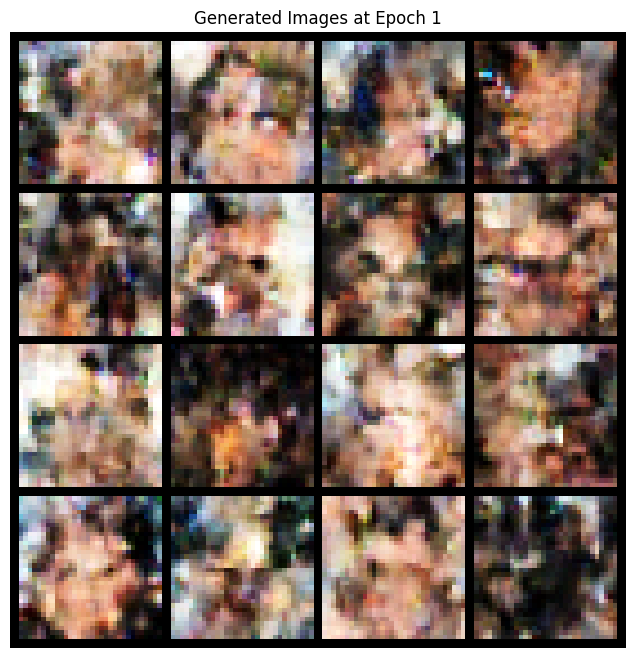

2025-06-21 23:11:36 - INFO - ------------------------------
2025-06-21 23:11:40 - INFO - Epoch: 2/60 | Batch: 0/318 | Loss (NLL): -6740.5098 | BPD: 4.8345
2025-06-21 23:14:01 - INFO - Epoch: 2/60 | Batch: 50/318 | Loss (NLL): -6834.5781 | BPD: 4.7903
2025-06-21 23:16:21 - INFO - Epoch: 2/60 | Batch: 100/318 | Loss (NLL): -6818.9634 | BPD: 4.7976
2025-06-21 23:18:42 - INFO - Epoch: 2/60 | Batch: 150/318 | Loss (NLL): -6896.3359 | BPD: 4.7613
2025-06-21 23:21:02 - INFO - Epoch: 2/60 | Batch: 200/318 | Loss (NLL): -7151.1865 | BPD: 4.6416
2025-06-21 23:23:22 - INFO - Epoch: 2/60 | Batch: 250/318 | Loss (NLL): -7329.6318 | BPD: 4.5578
2025-06-21 23:25:42 - INFO - Epoch: 2/60 | Batch: 300/318 | Loss (NLL): -7273.3838 | BPD: 4.5842
2025-06-21 23:26:29 - INFO - --- Epoch 2 Summary ---
2025-06-21 23:26:29 - INFO - Average Loss: -7053.1352 | Time: 893.42s
2025-06-21 23:26:29 - INFO - Generating sample images...


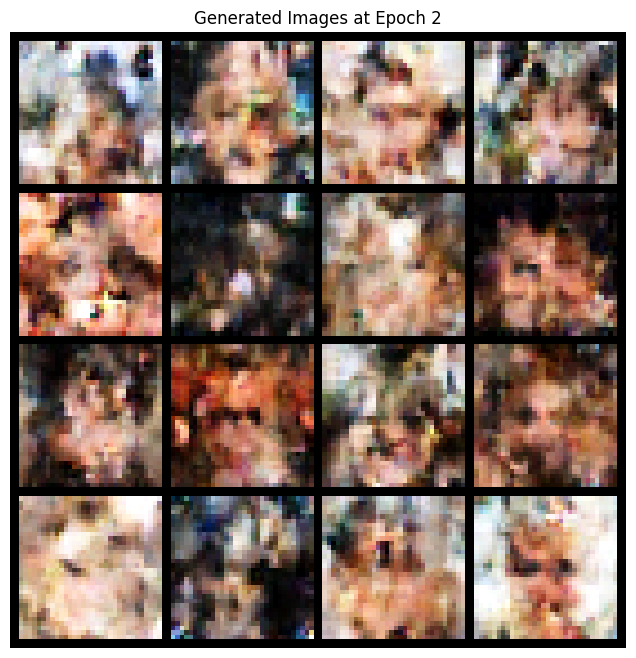

2025-06-21 23:26:30 - INFO - ------------------------------
2025-06-21 23:26:34 - INFO - Epoch: 3/60 | Batch: 0/318 | Loss (NLL): -7292.8086 | BPD: 4.5751
2025-06-21 23:28:55 - INFO - Epoch: 3/60 | Batch: 50/318 | Loss (NLL): -7413.5684 | BPD: 4.5184
2025-06-21 23:31:16 - INFO - Epoch: 3/60 | Batch: 100/318 | Loss (NLL): -7684.1338 | BPD: 4.3913
2025-06-21 23:33:37 - INFO - Epoch: 3/60 | Batch: 150/318 | Loss (NLL): -7491.2192 | BPD: 4.4819
2025-06-21 23:35:58 - INFO - Epoch: 3/60 | Batch: 200/318 | Loss (NLL): -7723.0420 | BPD: 4.3730
2025-06-21 23:38:19 - INFO - Epoch: 3/60 | Batch: 250/318 | Loss (NLL): -7399.9004 | BPD: 4.5248
2025-06-21 23:40:39 - INFO - Epoch: 3/60 | Batch: 300/318 | Loss (NLL): -7637.1992 | BPD: 4.4134
2025-06-21 23:41:27 - INFO - --- Epoch 3 Summary ---
2025-06-21 23:41:27 - INFO - Average Loss: -7489.9582 | Time: 896.70s
2025-06-21 23:41:27 - INFO - Generating sample images...


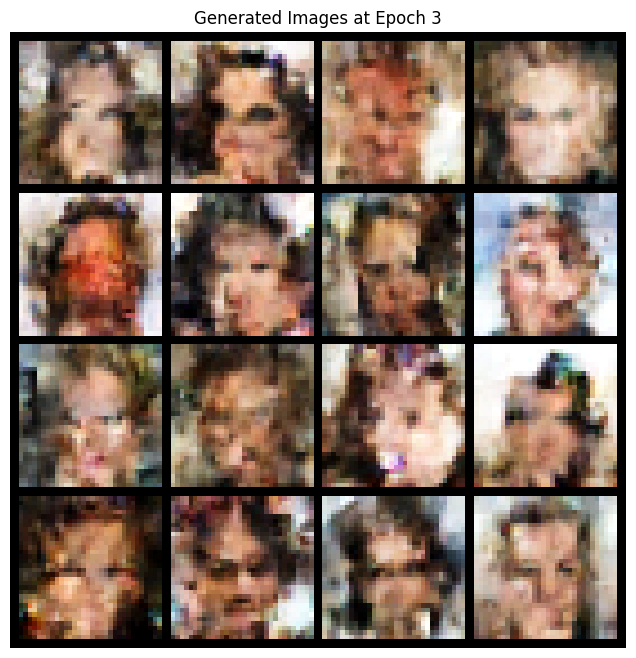

2025-06-21 23:41:27 - INFO - ------------------------------
2025-06-21 23:41:32 - INFO - Epoch: 4/60 | Batch: 0/318 | Loss (NLL): -7680.1035 | BPD: 4.3932
2025-06-21 23:43:53 - INFO - Epoch: 4/60 | Batch: 50/318 | Loss (NLL): -7618.2461 | BPD: 4.4223
2025-06-21 23:46:14 - INFO - Epoch: 4/60 | Batch: 100/318 | Loss (NLL): -7824.6919 | BPD: 4.3253
2025-06-21 23:48:35 - INFO - Epoch: 4/60 | Batch: 150/318 | Loss (NLL): -7633.2549 | BPD: 4.4152
2025-06-21 23:50:55 - INFO - Epoch: 4/60 | Batch: 200/318 | Loss (NLL): -7895.7900 | BPD: 4.2919
2025-06-21 23:53:15 - INFO - Epoch: 4/60 | Batch: 250/318 | Loss (NLL): -7881.8525 | BPD: 4.2985
2025-06-21 23:55:35 - INFO - Epoch: 4/60 | Batch: 300/318 | Loss (NLL): -7682.7051 | BPD: 4.3920
2025-06-21 23:56:23 - INFO - --- Epoch 4 Summary ---
2025-06-21 23:56:23 - INFO - Average Loss: -7670.7717 | Time: 895.60s
2025-06-21 23:56:23 - INFO - Generating sample images...


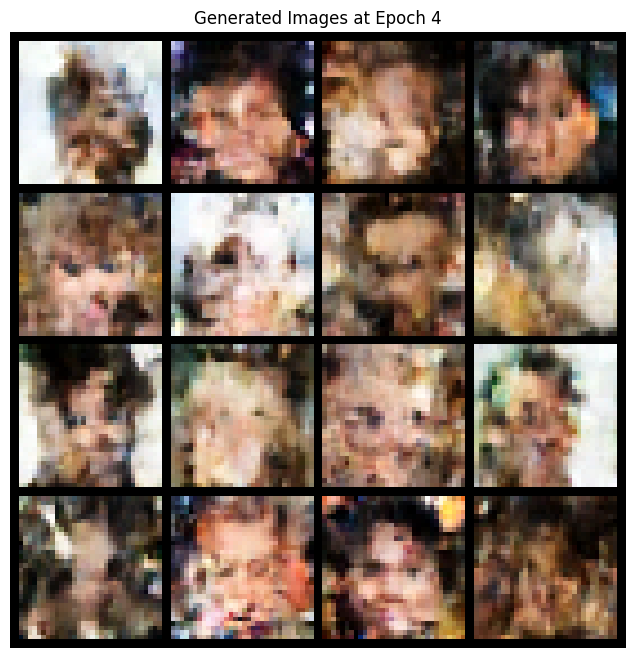

2025-06-21 23:56:24 - INFO - ------------------------------
2025-06-21 23:56:28 - INFO - Epoch: 5/60 | Batch: 0/318 | Loss (NLL): -7543.2642 | BPD: 4.4575
2025-06-21 23:58:49 - INFO - Epoch: 5/60 | Batch: 50/318 | Loss (NLL): -7808.4126 | BPD: 4.3330
2025-06-22 00:01:09 - INFO - Epoch: 5/60 | Batch: 100/318 | Loss (NLL): -7780.6909 | BPD: 4.3460
2025-06-22 00:03:29 - INFO - Epoch: 5/60 | Batch: 150/318 | Loss (NLL): -7580.0083 | BPD: 4.4402
2025-06-22 00:05:50 - INFO - Epoch: 5/60 | Batch: 200/318 | Loss (NLL): -7858.2734 | BPD: 4.3095
2025-06-22 00:08:11 - INFO - Epoch: 5/60 | Batch: 250/318 | Loss (NLL): -7757.9795 | BPD: 4.3566
2025-06-22 00:10:32 - INFO - Epoch: 5/60 | Batch: 300/318 | Loss (NLL): -7940.5264 | BPD: 4.2709
2025-06-22 00:11:20 - INFO - --- Epoch 5 Summary ---
2025-06-22 00:11:20 - INFO - Average Loss: -7807.3639 | Time: 896.35s
2025-06-22 00:11:20 - INFO - Generating sample images...


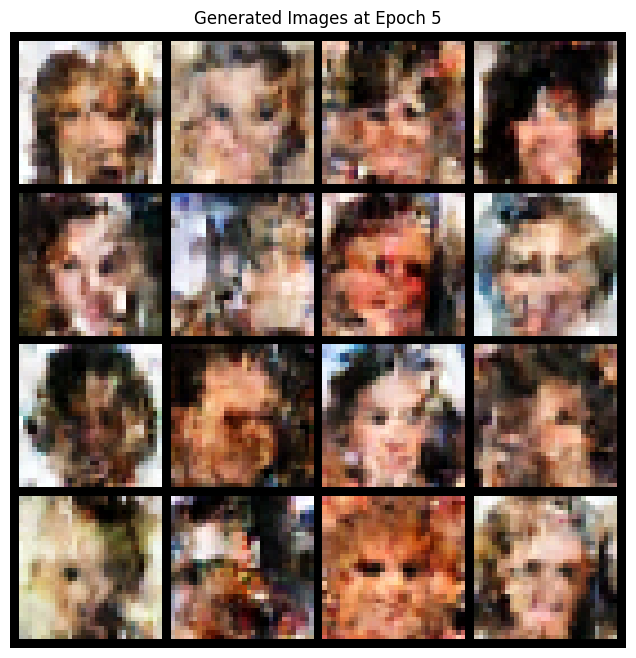

2025-06-22 00:11:20 - INFO - ------------------------------
2025-06-22 00:11:25 - INFO - Epoch: 6/60 | Batch: 0/318 | Loss (NLL): -7826.2168 | BPD: 4.3246
2025-06-22 00:13:45 - INFO - Epoch: 6/60 | Batch: 50/318 | Loss (NLL): -7793.1426 | BPD: 4.3401
2025-06-22 00:16:06 - INFO - Epoch: 6/60 | Batch: 100/318 | Loss (NLL): -8016.7925 | BPD: 4.2351
2025-06-22 00:18:25 - INFO - Epoch: 6/60 | Batch: 150/318 | Loss (NLL): -7767.1348 | BPD: 4.3523
2025-06-22 00:20:47 - INFO - Epoch: 6/60 | Batch: 200/318 | Loss (NLL): -7954.9365 | BPD: 4.2641
2025-06-22 00:23:07 - INFO - Epoch: 6/60 | Batch: 250/318 | Loss (NLL): -7949.8369 | BPD: 4.2665
2025-06-22 00:25:28 - INFO - Epoch: 6/60 | Batch: 300/318 | Loss (NLL): -7880.5947 | BPD: 4.2991
2025-06-22 00:26:15 - INFO - --- Epoch 6 Summary ---
2025-06-22 00:26:15 - INFO - Average Loss: -7920.2339 | Time: 894.53s
2025-06-22 00:26:15 - INFO - Generating sample images...


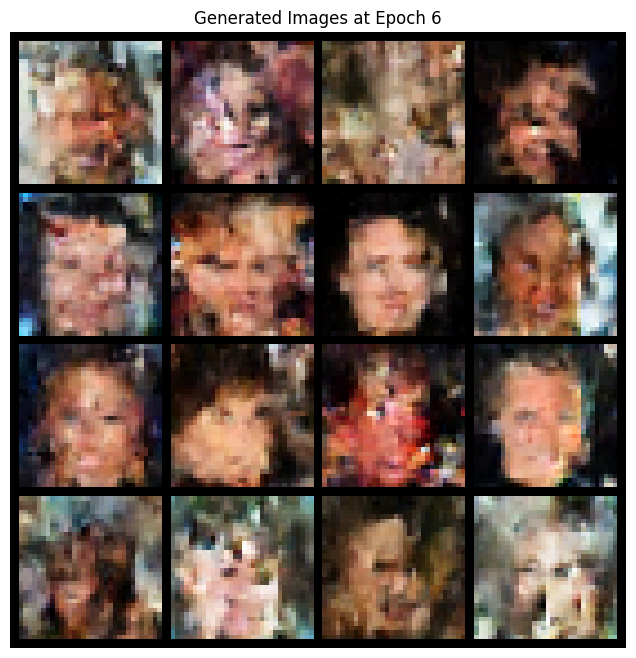

2025-06-22 00:26:15 - INFO - ------------------------------
2025-06-22 00:26:20 - INFO - Epoch: 7/60 | Batch: 0/318 | Loss (NLL): -7891.1772 | BPD: 4.2941
2025-06-22 00:28:41 - INFO - Epoch: 7/60 | Batch: 50/318 | Loss (NLL): -7990.7246 | BPD: 4.2473
2025-06-22 00:31:02 - INFO - Epoch: 7/60 | Batch: 100/318 | Loss (NLL): -8114.6777 | BPD: 4.1891
2025-06-22 00:33:23 - INFO - Epoch: 7/60 | Batch: 150/318 | Loss (NLL): -7761.1416 | BPD: 4.3552
2025-06-22 00:35:44 - INFO - Epoch: 7/60 | Batch: 200/318 | Loss (NLL): -7946.7129 | BPD: 4.2680
2025-06-22 00:38:06 - INFO - Epoch: 7/60 | Batch: 250/318 | Loss (NLL): -7908.2490 | BPD: 4.2861
2025-06-22 00:40:28 - INFO - Epoch: 7/60 | Batch: 300/318 | Loss (NLL): -8073.0186 | BPD: 4.2087
2025-06-22 00:41:16 - INFO - --- Epoch 7 Summary ---
2025-06-22 00:41:16 - INFO - Average Loss: -8016.9845 | Time: 900.48s
2025-06-22 00:41:16 - INFO - Generating sample images...


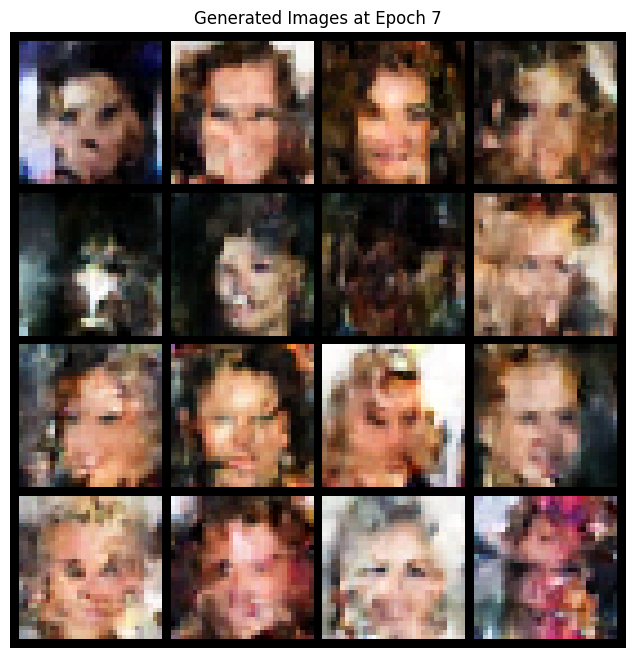

2025-06-22 00:41:16 - INFO - ------------------------------
2025-06-22 00:41:21 - INFO - Epoch: 8/60 | Batch: 0/318 | Loss (NLL): -8036.0405 | BPD: 4.2261
2025-06-22 00:43:43 - INFO - Epoch: 8/60 | Batch: 50/318 | Loss (NLL): -8164.8594 | BPD: 4.1656
2025-06-22 00:46:04 - INFO - Epoch: 8/60 | Batch: 100/318 | Loss (NLL): -8027.2793 | BPD: 4.2302
2025-06-22 00:48:25 - INFO - Epoch: 8/60 | Batch: 150/318 | Loss (NLL): -8114.1963 | BPD: 4.1894
2025-06-22 00:50:47 - INFO - Epoch: 8/60 | Batch: 200/318 | Loss (NLL): -8163.3711 | BPD: 4.1663
2025-06-22 00:53:09 - INFO - Epoch: 8/60 | Batch: 250/318 | Loss (NLL): -8177.2783 | BPD: 4.1597
2025-06-22 00:55:31 - INFO - Epoch: 8/60 | Batch: 300/318 | Loss (NLL): -8137.9331 | BPD: 4.1782
2025-06-22 00:56:20 - INFO - --- Epoch 8 Summary ---
2025-06-22 00:56:20 - INFO - Average Loss: -8113.6717 | Time: 903.18s
2025-06-22 00:56:20 - INFO - Generating sample images...


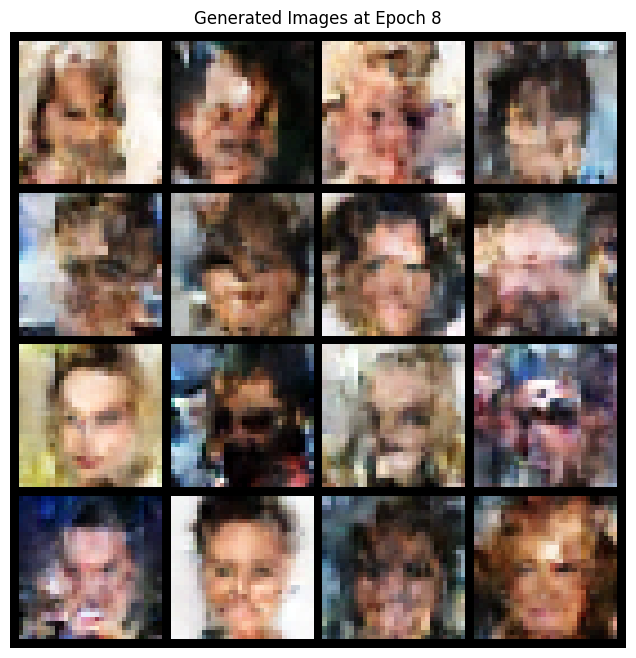

2025-06-22 00:56:20 - INFO - ------------------------------
2025-06-22 00:56:25 - INFO - Epoch: 9/60 | Batch: 0/318 | Loss (NLL): -8084.3955 | BPD: 4.2033
2025-06-22 00:58:47 - INFO - Epoch: 9/60 | Batch: 50/318 | Loss (NLL): -8205.5176 | BPD: 4.1465
2025-06-22 01:01:08 - INFO - Epoch: 9/60 | Batch: 100/318 | Loss (NLL): -8089.3872 | BPD: 4.2010
2025-06-22 01:03:29 - INFO - Epoch: 9/60 | Batch: 150/318 | Loss (NLL): -8195.0371 | BPD: 4.1514
2025-06-22 01:05:50 - INFO - Epoch: 9/60 | Batch: 200/318 | Loss (NLL): -8171.8018 | BPD: 4.1623
2025-06-22 01:08:11 - INFO - Epoch: 9/60 | Batch: 250/318 | Loss (NLL): -8340.3174 | BPD: 4.0832
2025-06-22 01:10:32 - INFO - Epoch: 9/60 | Batch: 300/318 | Loss (NLL): -8195.7188 | BPD: 4.1511
2025-06-22 01:11:20 - INFO - --- Epoch 9 Summary ---
2025-06-22 01:11:20 - INFO - Average Loss: -8179.7998 | Time: 899.47s
2025-06-22 01:11:20 - INFO - Generating sample images...


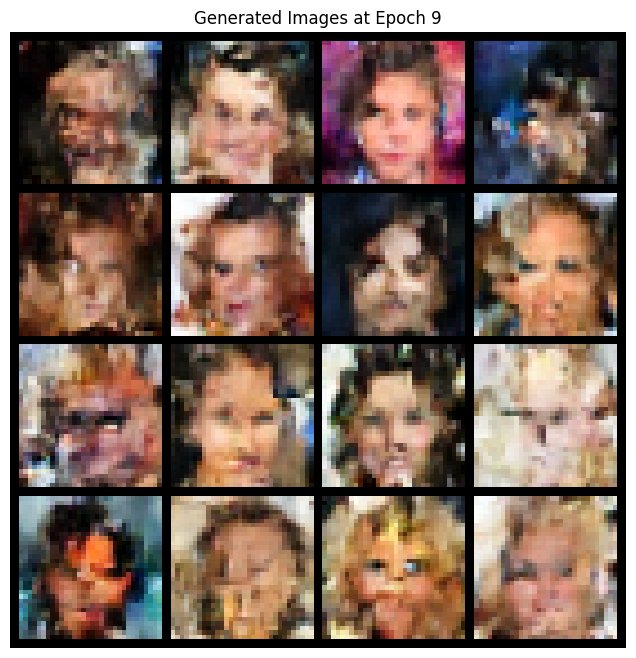

2025-06-22 01:11:20 - INFO - ------------------------------
2025-06-22 01:11:25 - INFO - Epoch: 10/60 | Batch: 0/318 | Loss (NLL): -8215.5859 | BPD: 4.1417
2025-06-22 01:13:46 - INFO - Epoch: 10/60 | Batch: 50/318 | Loss (NLL): -8218.0117 | BPD: 4.1406
2025-06-22 01:16:08 - INFO - Epoch: 10/60 | Batch: 100/318 | Loss (NLL): -8302.8066 | BPD: 4.1008
2025-06-22 01:18:30 - INFO - Epoch: 10/60 | Batch: 150/318 | Loss (NLL): -8364.3213 | BPD: 4.0719
2025-06-22 01:20:52 - INFO - Epoch: 10/60 | Batch: 200/318 | Loss (NLL): -8217.5762 | BPD: 4.1408
2025-06-22 01:23:13 - INFO - Epoch: 10/60 | Batch: 250/318 | Loss (NLL): -8246.1875 | BPD: 4.1274
2025-06-22 01:25:34 - INFO - Epoch: 10/60 | Batch: 300/318 | Loss (NLL): -8240.9766 | BPD: 4.1298
2025-06-22 01:26:22 - INFO - --- Epoch 10 Summary ---
2025-06-22 01:26:22 - INFO - Average Loss: -8246.3032 | Time: 901.99s
2025-06-22 01:26:22 - INFO - Generating sample images...


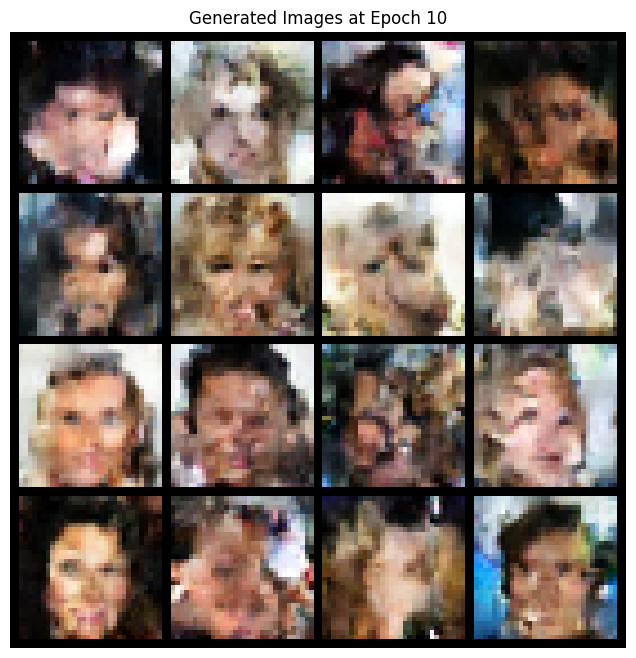

2025-06-22 01:26:23 - INFO - ------------------------------
2025-06-22 01:26:27 - INFO - Epoch: 11/60 | Batch: 0/318 | Loss (NLL): -8213.0420 | BPD: 4.1429
2025-06-22 01:28:49 - INFO - Epoch: 11/60 | Batch: 50/318 | Loss (NLL): -8303.2500 | BPD: 4.1006
2025-06-22 01:31:11 - INFO - Epoch: 11/60 | Batch: 100/318 | Loss (NLL): -8230.5293 | BPD: 4.1347
2025-06-22 01:33:32 - INFO - Epoch: 11/60 | Batch: 150/318 | Loss (NLL): -8130.7739 | BPD: 4.1816
2025-06-22 01:35:54 - INFO - Epoch: 11/60 | Batch: 200/318 | Loss (NLL): -8339.1611 | BPD: 4.0837
2025-06-22 01:38:15 - INFO - Epoch: 11/60 | Batch: 250/318 | Loss (NLL): -8320.4092 | BPD: 4.0925
2025-06-22 01:40:37 - INFO - Epoch: 11/60 | Batch: 300/318 | Loss (NLL): -8267.3662 | BPD: 4.1174
2025-06-22 01:41:25 - INFO - --- Epoch 11 Summary ---
2025-06-22 01:41:25 - INFO - Average Loss: -8296.5604 | Time: 902.45s
2025-06-22 01:41:25 - INFO - Generating sample images...


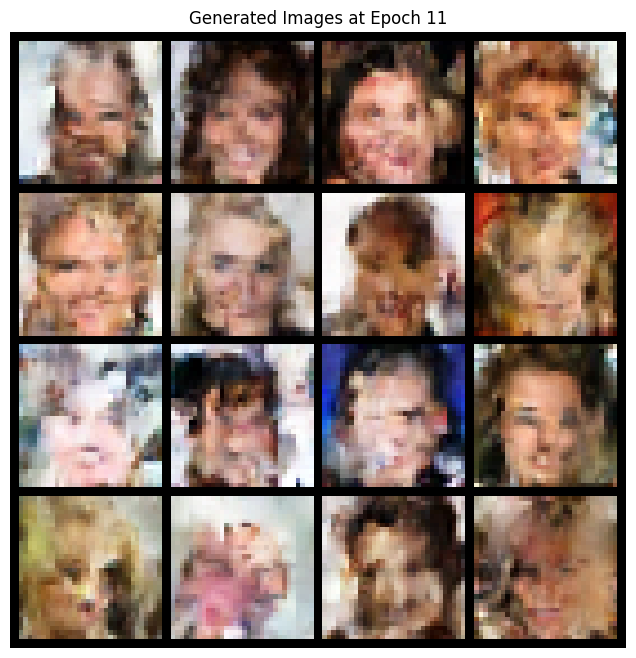

2025-06-22 01:41:25 - INFO - ------------------------------
2025-06-22 01:41:30 - INFO - Epoch: 12/60 | Batch: 0/318 | Loss (NLL): -8366.9541 | BPD: 4.0707
2025-06-22 01:43:52 - INFO - Epoch: 12/60 | Batch: 50/318 | Loss (NLL): -8462.9629 | BPD: 4.0256
2025-06-22 01:46:13 - INFO - Epoch: 12/60 | Batch: 100/318 | Loss (NLL): -8251.9355 | BPD: 4.1247
2025-06-22 01:48:36 - INFO - Epoch: 12/60 | Batch: 150/318 | Loss (NLL): -8363.0859 | BPD: 4.0725
2025-06-22 01:50:57 - INFO - Epoch: 12/60 | Batch: 200/318 | Loss (NLL): -8345.0615 | BPD: 4.0809
2025-06-22 01:53:19 - INFO - Epoch: 12/60 | Batch: 250/318 | Loss (NLL): -8424.4307 | BPD: 4.0437
2025-06-22 01:55:42 - INFO - Epoch: 12/60 | Batch: 300/318 | Loss (NLL): -8350.3496 | BPD: 4.0784
2025-06-22 01:56:31 - INFO - --- Epoch 12 Summary ---
2025-06-22 01:56:31 - INFO - Average Loss: -8342.5314 | Time: 905.39s
2025-06-22 01:56:31 - INFO - Generating sample images...


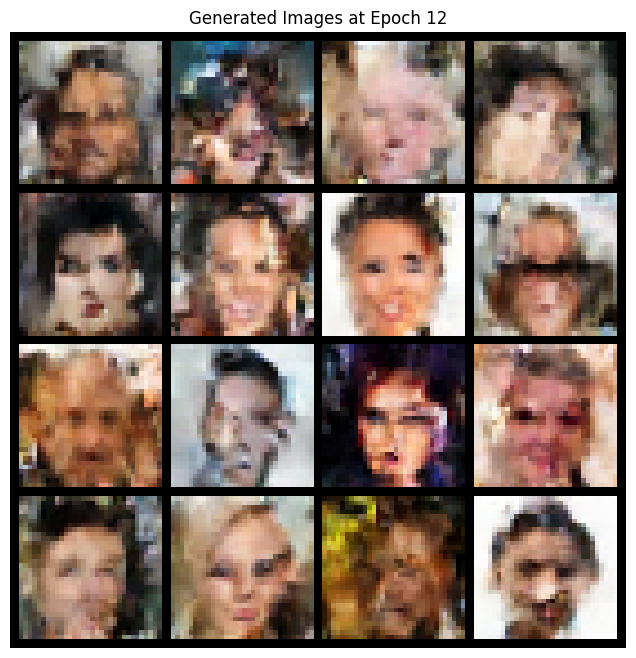

2025-06-22 01:56:31 - INFO - ------------------------------
2025-06-22 01:56:36 - INFO - Epoch: 13/60 | Batch: 0/318 | Loss (NLL): -8316.7402 | BPD: 4.0942
2025-06-22 01:59:01 - INFO - Epoch: 13/60 | Batch: 50/318 | Loss (NLL): -8440.9043 | BPD: 4.0359
2025-06-22 02:01:25 - INFO - Epoch: 13/60 | Batch: 100/318 | Loss (NLL): -8472.2539 | BPD: 4.0212
2025-06-22 02:03:49 - INFO - Epoch: 13/60 | Batch: 150/318 | Loss (NLL): -8318.9629 | BPD: 4.0932
2025-06-22 02:06:13 - INFO - Epoch: 13/60 | Batch: 200/318 | Loss (NLL): -8460.5889 | BPD: 4.0267
2025-06-22 02:08:37 - INFO - Epoch: 13/60 | Batch: 250/318 | Loss (NLL): -8368.2695 | BPD: 4.0700
2025-06-22 02:11:00 - INFO - Epoch: 13/60 | Batch: 300/318 | Loss (NLL): -8295.8984 | BPD: 4.1040
2025-06-22 02:11:48 - INFO - --- Epoch 13 Summary ---
2025-06-22 02:11:48 - INFO - Average Loss: -8364.7237 | Time: 916.22s
2025-06-22 02:11:48 - INFO - Generating sample images...


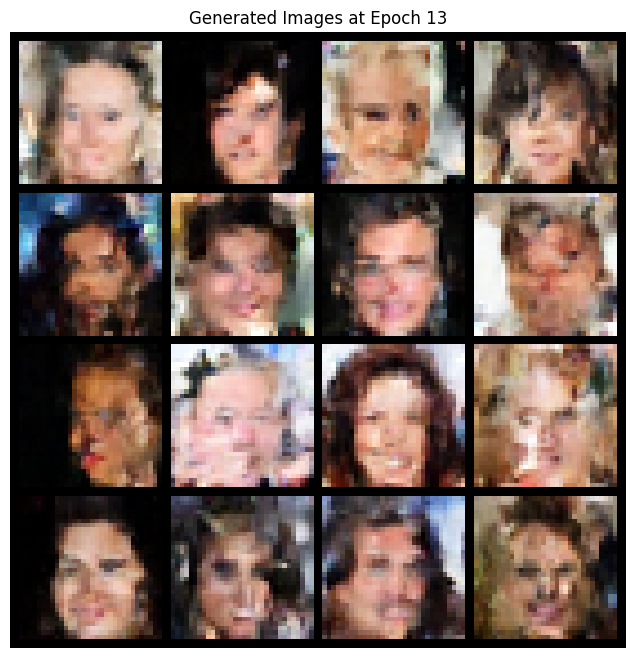

2025-06-22 02:11:48 - INFO - ------------------------------
2025-06-22 02:11:53 - INFO - Epoch: 14/60 | Batch: 0/318 | Loss (NLL): -8436.8398 | BPD: 4.0378
2025-06-22 02:14:14 - INFO - Epoch: 14/60 | Batch: 50/318 | Loss (NLL): -8442.2812 | BPD: 4.0353
2025-06-22 02:16:36 - INFO - Epoch: 14/60 | Batch: 100/318 | Loss (NLL): -8358.7588 | BPD: 4.0745
2025-06-22 02:18:58 - INFO - Epoch: 14/60 | Batch: 150/318 | Loss (NLL): -8289.7373 | BPD: 4.1069
2025-06-22 02:21:19 - INFO - Epoch: 14/60 | Batch: 200/318 | Loss (NLL): -8433.7402 | BPD: 4.0393
2025-06-22 02:23:41 - INFO - Epoch: 14/60 | Batch: 250/318 | Loss (NLL): -8405.8408 | BPD: 4.0524
2025-06-22 02:26:03 - INFO - Epoch: 14/60 | Batch: 300/318 | Loss (NLL): -8349.9678 | BPD: 4.0786
2025-06-22 02:26:51 - INFO - --- Epoch 14 Summary ---
2025-06-22 02:26:51 - INFO - Average Loss: -8409.5827 | Time: 903.05s
2025-06-22 02:26:51 - INFO - Generating sample images...


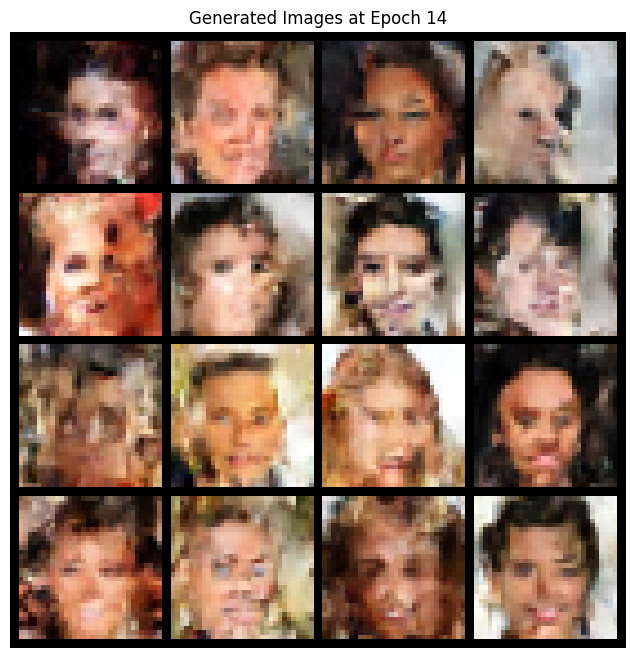

2025-06-22 02:26:52 - INFO - ------------------------------
2025-06-22 02:26:56 - INFO - Epoch: 15/60 | Batch: 0/318 | Loss (NLL): -8486.9385 | BPD: 4.0143
2025-06-22 02:29:18 - INFO - Epoch: 15/60 | Batch: 50/318 | Loss (NLL): -8462.9473 | BPD: 4.0256
2025-06-22 02:31:40 - INFO - Epoch: 15/60 | Batch: 100/318 | Loss (NLL): -8391.9150 | BPD: 4.0589
2025-06-22 02:34:02 - INFO - Epoch: 15/60 | Batch: 150/318 | Loss (NLL): -8513.1445 | BPD: 4.0020
2025-06-22 02:36:25 - INFO - Epoch: 15/60 | Batch: 200/318 | Loss (NLL): -8513.9375 | BPD: 4.0016
2025-06-22 02:38:47 - INFO - Epoch: 15/60 | Batch: 250/318 | Loss (NLL): -8405.3291 | BPD: 4.0526
2025-06-22 02:41:09 - INFO - Epoch: 15/60 | Batch: 300/318 | Loss (NLL): -8522.0215 | BPD: 3.9978
2025-06-22 02:41:58 - INFO - --- Epoch 15 Summary ---
2025-06-22 02:41:58 - INFO - Average Loss: -8450.9740 | Time: 905.89s
2025-06-22 02:41:58 - INFO - Generating sample images...


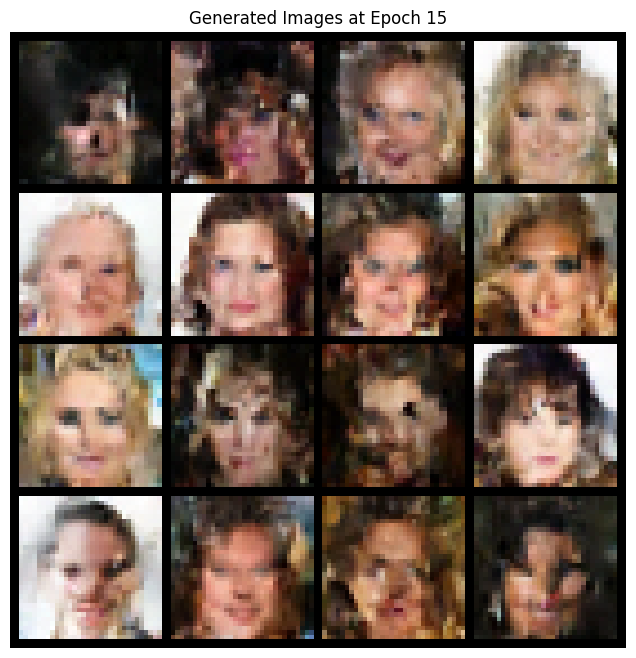

2025-06-22 02:41:58 - INFO - ------------------------------
2025-06-22 02:42:02 - INFO - Epoch: 16/60 | Batch: 0/318 | Loss (NLL): -8456.0234 | BPD: 4.0288
2025-06-22 02:44:25 - INFO - Epoch: 16/60 | Batch: 50/318 | Loss (NLL): -8491.1348 | BPD: 4.0123
2025-06-22 02:46:46 - INFO - Epoch: 16/60 | Batch: 100/318 | Loss (NLL): -8565.9561 | BPD: 3.9772
2025-06-22 02:49:08 - INFO - Epoch: 16/60 | Batch: 150/318 | Loss (NLL): -8535.8975 | BPD: 3.9913
2025-06-22 02:51:30 - INFO - Epoch: 16/60 | Batch: 200/318 | Loss (NLL): -8504.2617 | BPD: 4.0062
2025-06-22 02:53:52 - INFO - Epoch: 16/60 | Batch: 250/318 | Loss (NLL): -8567.1172 | BPD: 3.9766
2025-06-22 02:56:14 - INFO - Epoch: 16/60 | Batch: 300/318 | Loss (NLL): -8579.9023 | BPD: 3.9706
2025-06-22 02:57:02 - INFO - --- Epoch 16 Summary ---
2025-06-22 02:57:02 - INFO - Average Loss: -8495.2500 | Time: 903.90s
2025-06-22 02:57:02 - INFO - Generating sample images...


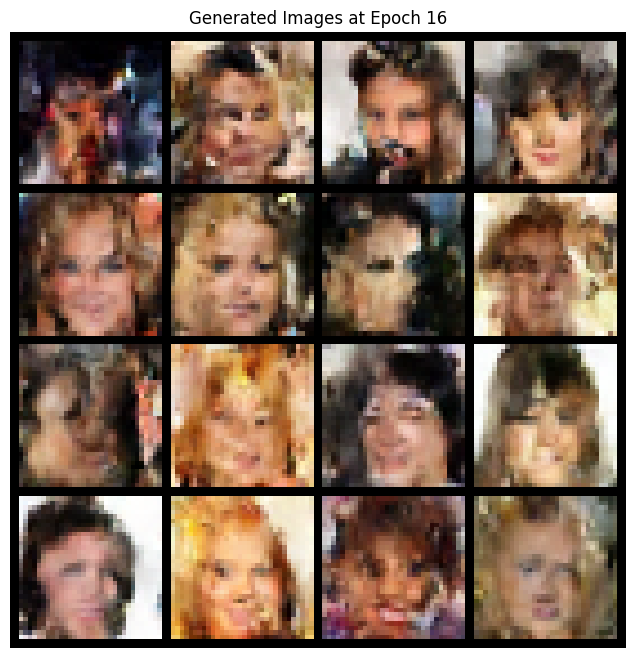

2025-06-22 02:57:02 - INFO - ------------------------------
2025-06-22 02:57:07 - INFO - Epoch: 17/60 | Batch: 0/318 | Loss (NLL): -8574.4531 | BPD: 3.9732
2025-06-22 02:59:29 - INFO - Epoch: 17/60 | Batch: 50/318 | Loss (NLL): -8514.6875 | BPD: 4.0013
2025-06-22 03:01:50 - INFO - Epoch: 17/60 | Batch: 100/318 | Loss (NLL): -8535.2578 | BPD: 3.9916
2025-06-22 03:04:12 - INFO - Epoch: 17/60 | Batch: 150/318 | Loss (NLL): -8498.9170 | BPD: 4.0087
2025-06-22 03:06:33 - INFO - Epoch: 17/60 | Batch: 200/318 | Loss (NLL): -8478.3477 | BPD: 4.0183
2025-06-22 03:08:56 - INFO - Epoch: 17/60 | Batch: 250/318 | Loss (NLL): -8569.4805 | BPD: 3.9755
2025-06-22 03:11:19 - INFO - Epoch: 17/60 | Batch: 300/318 | Loss (NLL): -8544.5078 | BPD: 3.9873
2025-06-22 03:12:07 - INFO - --- Epoch 17 Summary ---
2025-06-22 03:12:07 - INFO - Average Loss: -8521.0841 | Time: 904.48s
2025-06-22 03:12:07 - INFO - Generating sample images...


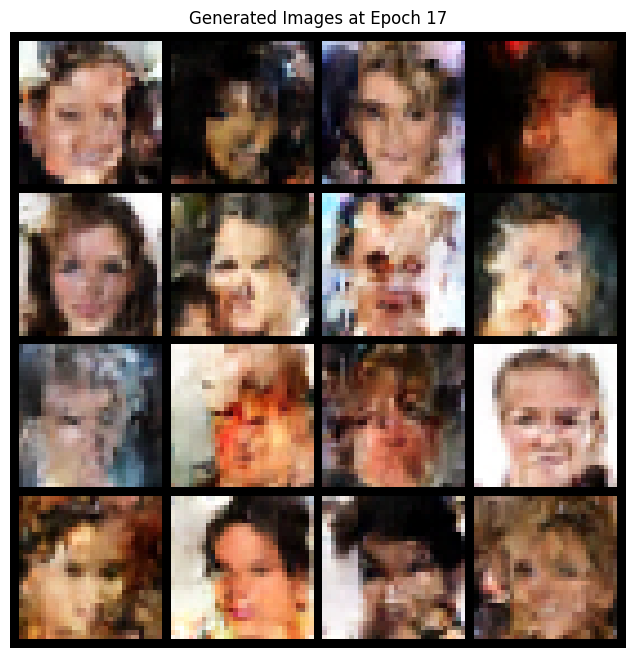

2025-06-22 03:12:07 - INFO - ------------------------------
2025-06-22 03:12:12 - INFO - Epoch: 18/60 | Batch: 0/318 | Loss (NLL): -8453.7334 | BPD: 4.0299
2025-06-22 03:14:34 - INFO - Epoch: 18/60 | Batch: 50/318 | Loss (NLL): -8551.6377 | BPD: 3.9839
2025-06-22 03:16:55 - INFO - Epoch: 18/60 | Batch: 100/318 | Loss (NLL): -8618.1914 | BPD: 3.9527
2025-06-22 03:19:18 - INFO - Epoch: 18/60 | Batch: 150/318 | Loss (NLL): -8595.5244 | BPD: 3.9633
2025-06-22 03:21:43 - INFO - Epoch: 18/60 | Batch: 200/318 | Loss (NLL): -8607.4434 | BPD: 3.9577
2025-06-22 03:24:04 - INFO - Epoch: 18/60 | Batch: 250/318 | Loss (NLL): -8523.2812 | BPD: 3.9972
2025-06-22 03:26:25 - INFO - Epoch: 18/60 | Batch: 300/318 | Loss (NLL): -8670.3926 | BPD: 3.9281
2025-06-22 03:27:13 - INFO - --- Epoch 18 Summary ---
2025-06-22 03:27:13 - INFO - Average Loss: -8548.7975 | Time: 905.72s
2025-06-22 03:27:13 - INFO - Generating sample images...


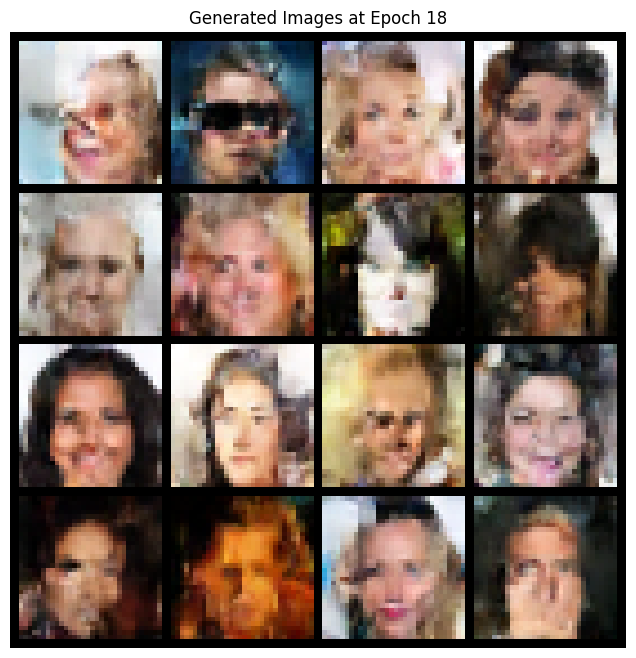

2025-06-22 03:27:14 - INFO - ------------------------------
2025-06-22 03:27:18 - INFO - Epoch: 19/60 | Batch: 0/318 | Loss (NLL): -8536.4072 | BPD: 3.9911
2025-06-22 03:29:40 - INFO - Epoch: 19/60 | Batch: 50/318 | Loss (NLL): -8632.5645 | BPD: 3.9459
2025-06-22 03:32:01 - INFO - Epoch: 19/60 | Batch: 100/318 | Loss (NLL): -8583.4902 | BPD: 3.9690
2025-06-22 03:34:23 - INFO - Epoch: 19/60 | Batch: 150/318 | Loss (NLL): -8639.7158 | BPD: 3.9426
2025-06-22 03:36:46 - INFO - Epoch: 19/60 | Batch: 200/318 | Loss (NLL): -8452.2119 | BPD: 4.0306
2025-06-22 03:39:08 - INFO - Epoch: 19/60 | Batch: 250/318 | Loss (NLL): -8529.4199 | BPD: 3.9944
2025-06-22 03:41:30 - INFO - Epoch: 19/60 | Batch: 300/318 | Loss (NLL): -8587.8516 | BPD: 3.9669
2025-06-22 03:42:18 - INFO - --- Epoch 19 Summary ---
2025-06-22 03:42:18 - INFO - Average Loss: -8561.4217 | Time: 904.00s
2025-06-22 03:42:18 - INFO - Generating sample images...


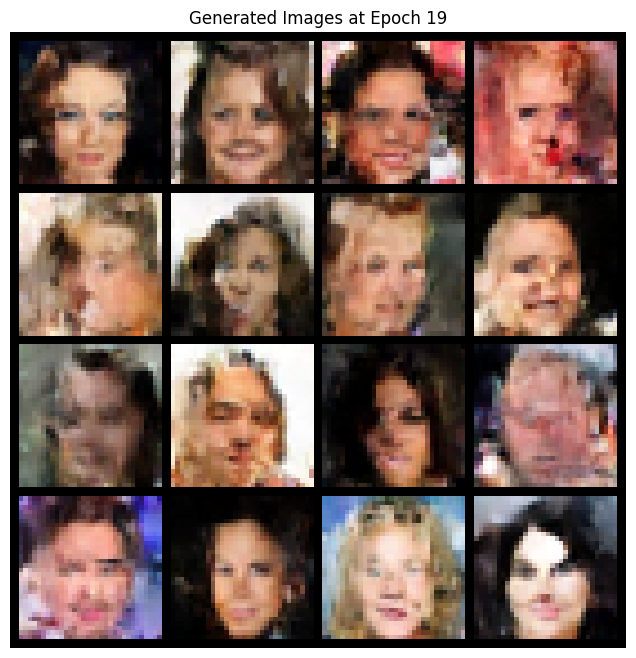

2025-06-22 03:42:18 - INFO - ------------------------------
2025-06-22 03:42:23 - INFO - Epoch: 20/60 | Batch: 0/318 | Loss (NLL): -8673.3174 | BPD: 3.9268
2025-06-22 03:44:45 - INFO - Epoch: 20/60 | Batch: 50/318 | Loss (NLL): -8566.3369 | BPD: 3.9770
2025-06-22 03:47:07 - INFO - Epoch: 20/60 | Batch: 100/318 | Loss (NLL): -8573.6328 | BPD: 3.9736
2025-06-22 03:49:28 - INFO - Epoch: 20/60 | Batch: 150/318 | Loss (NLL): -8686.9307 | BPD: 3.9204
2025-06-22 03:51:49 - INFO - Epoch: 20/60 | Batch: 200/318 | Loss (NLL): -8616.1201 | BPD: 3.9536
2025-06-22 03:54:11 - INFO - Epoch: 20/60 | Batch: 250/318 | Loss (NLL): -8455.1211 | BPD: 4.0292
2025-06-22 03:56:32 - INFO - Epoch: 20/60 | Batch: 300/318 | Loss (NLL): -8650.3359 | BPD: 3.9376
2025-06-22 03:57:20 - INFO - --- Epoch 20 Summary ---
2025-06-22 03:57:20 - INFO - Average Loss: -8601.3421 | Time: 901.43s
2025-06-22 03:57:20 - INFO - Generating sample images...


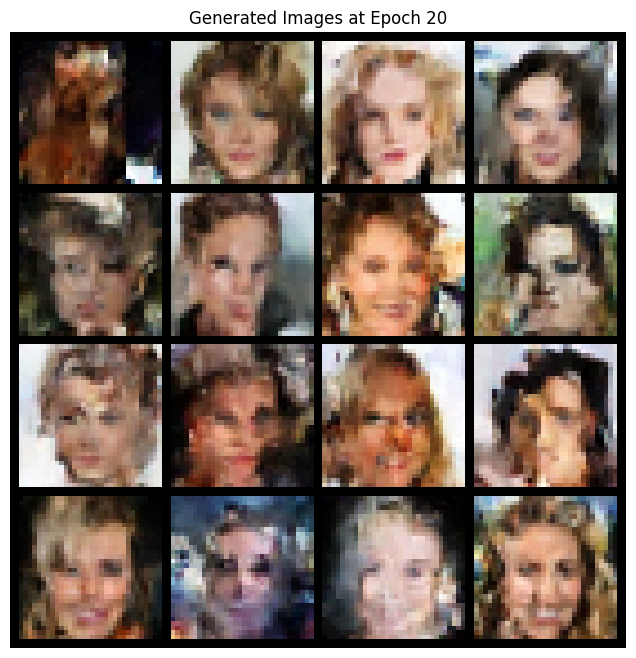

2025-06-22 03:57:20 - INFO - ------------------------------
2025-06-22 03:57:25 - INFO - Epoch: 21/60 | Batch: 0/318 | Loss (NLL): -8398.4346 | BPD: 4.0559
2025-06-22 03:59:46 - INFO - Epoch: 21/60 | Batch: 50/318 | Loss (NLL): -8587.8359 | BPD: 3.9669
2025-06-22 04:02:09 - INFO - Epoch: 21/60 | Batch: 100/318 | Loss (NLL): -8536.8594 | BPD: 3.9909
2025-06-22 04:04:30 - INFO - Epoch: 21/60 | Batch: 150/318 | Loss (NLL): -8527.8887 | BPD: 3.9951
2025-06-22 04:06:54 - INFO - Epoch: 21/60 | Batch: 200/318 | Loss (NLL): -8624.0469 | BPD: 3.9499
2025-06-22 04:09:19 - INFO - Epoch: 21/60 | Batch: 250/318 | Loss (NLL): -8561.1650 | BPD: 3.9794
2025-06-22 04:11:45 - INFO - Epoch: 21/60 | Batch: 300/318 | Loss (NLL): -8560.9082 | BPD: 3.9796
2025-06-22 04:12:35 - INFO - --- Epoch 21 Summary ---
2025-06-22 04:12:35 - INFO - Average Loss: -8607.9583 | Time: 914.59s
2025-06-22 04:12:35 - INFO - Generating sample images...


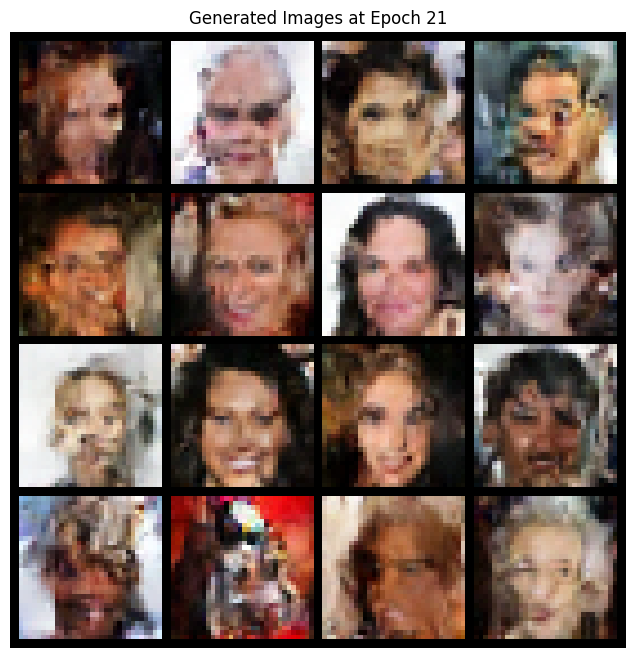

2025-06-22 04:12:35 - INFO - ------------------------------
2025-06-22 04:12:40 - INFO - Epoch: 22/60 | Batch: 0/318 | Loss (NLL): -8373.2129 | BPD: 4.0677
2025-06-22 04:15:05 - INFO - Epoch: 22/60 | Batch: 50/318 | Loss (NLL): -8758.6875 | BPD: 3.8867
2025-06-22 04:17:31 - INFO - Epoch: 22/60 | Batch: 100/318 | Loss (NLL): -8631.3613 | BPD: 3.9465
2025-06-22 04:19:54 - INFO - Epoch: 22/60 | Batch: 150/318 | Loss (NLL): -8546.6875 | BPD: 3.9862
2025-06-22 04:22:15 - INFO - Epoch: 22/60 | Batch: 200/318 | Loss (NLL): -8580.3438 | BPD: 3.9704
2025-06-22 04:24:37 - INFO - Epoch: 22/60 | Batch: 250/318 | Loss (NLL): -8649.2422 | BPD: 3.9381
2025-06-22 04:27:00 - INFO - Epoch: 22/60 | Batch: 300/318 | Loss (NLL): -8610.3750 | BPD: 3.9563
2025-06-22 04:27:48 - INFO - --- Epoch 22 Summary ---
2025-06-22 04:27:48 - INFO - Average Loss: -8624.4763 | Time: 912.85s
2025-06-22 04:27:48 - INFO - Generating sample images...


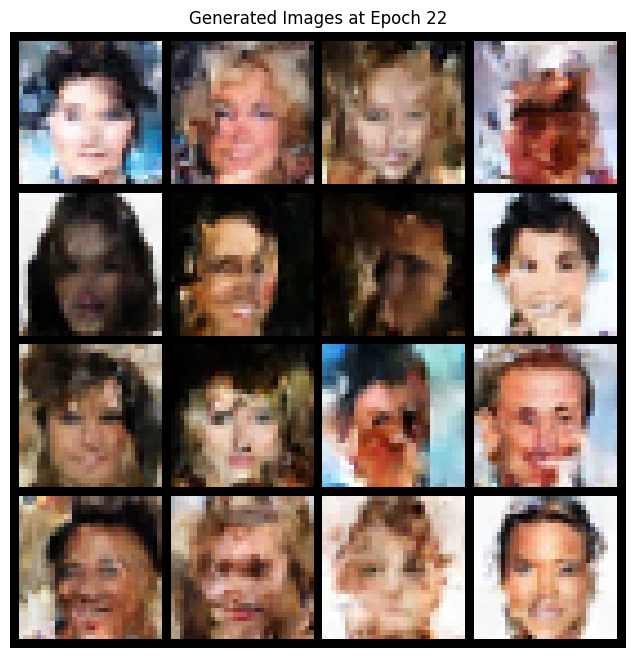

2025-06-22 04:27:49 - INFO - ------------------------------
2025-06-22 04:27:53 - INFO - Epoch: 23/60 | Batch: 0/318 | Loss (NLL): -8604.1074 | BPD: 3.9593
2025-06-22 04:30:15 - INFO - Epoch: 23/60 | Batch: 50/318 | Loss (NLL): -8522.4062 | BPD: 3.9976
2025-06-22 04:32:36 - INFO - Epoch: 23/60 | Batch: 100/318 | Loss (NLL): -8695.9785 | BPD: 3.9161
2025-06-22 04:34:58 - INFO - Epoch: 23/60 | Batch: 150/318 | Loss (NLL): -8640.9355 | BPD: 3.9420
2025-06-22 04:37:20 - INFO - Epoch: 23/60 | Batch: 200/318 | Loss (NLL): -8680.7109 | BPD: 3.9233
2025-06-22 04:39:42 - INFO - Epoch: 23/60 | Batch: 250/318 | Loss (NLL): -8665.4736 | BPD: 3.9305
2025-06-22 04:42:03 - INFO - Epoch: 23/60 | Batch: 300/318 | Loss (NLL): -8586.8877 | BPD: 3.9674
2025-06-22 04:42:51 - INFO - --- Epoch 23 Summary ---
2025-06-22 04:42:51 - INFO - Average Loss: -8647.6657 | Time: 902.58s
2025-06-22 04:42:51 - INFO - Generating sample images...


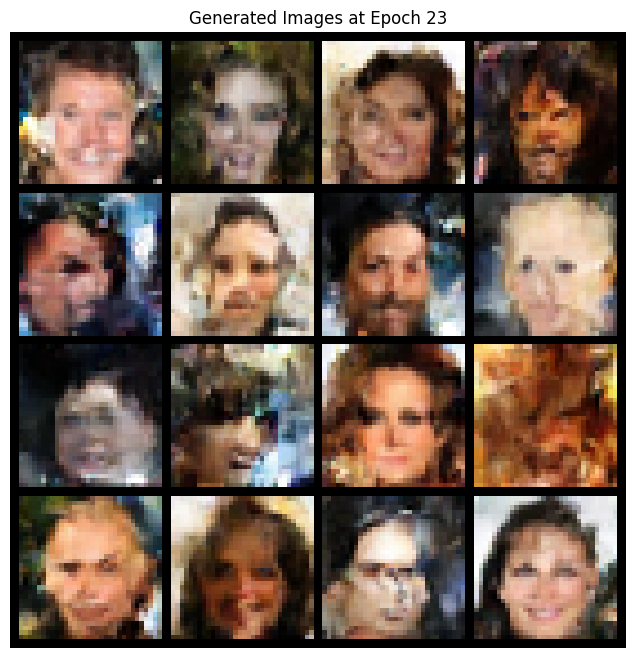

2025-06-22 04:42:52 - INFO - ------------------------------
2025-06-22 04:42:56 - INFO - Epoch: 24/60 | Batch: 0/318 | Loss (NLL): -8539.7812 | BPD: 3.9895
2025-06-22 04:45:18 - INFO - Epoch: 24/60 | Batch: 50/318 | Loss (NLL): -8670.9746 | BPD: 3.9279
2025-06-22 04:47:39 - INFO - Epoch: 24/60 | Batch: 100/318 | Loss (NLL): -8607.2598 | BPD: 3.9578
2025-06-22 04:50:00 - INFO - Epoch: 24/60 | Batch: 150/318 | Loss (NLL): -8661.2773 | BPD: 3.9324
2025-06-22 04:52:22 - INFO - Epoch: 24/60 | Batch: 200/318 | Loss (NLL): -8699.7695 | BPD: 3.9144
2025-06-22 04:54:43 - INFO - Epoch: 24/60 | Batch: 250/318 | Loss (NLL): -8735.4385 | BPD: 3.8976
2025-06-22 04:57:05 - INFO - Epoch: 24/60 | Batch: 300/318 | Loss (NLL): -8671.2471 | BPD: 3.9277
2025-06-22 04:57:53 - INFO - --- Epoch 24 Summary ---
2025-06-22 04:57:53 - INFO - Average Loss: -8692.6711 | Time: 901.30s
2025-06-22 04:57:53 - INFO - Generating sample images...


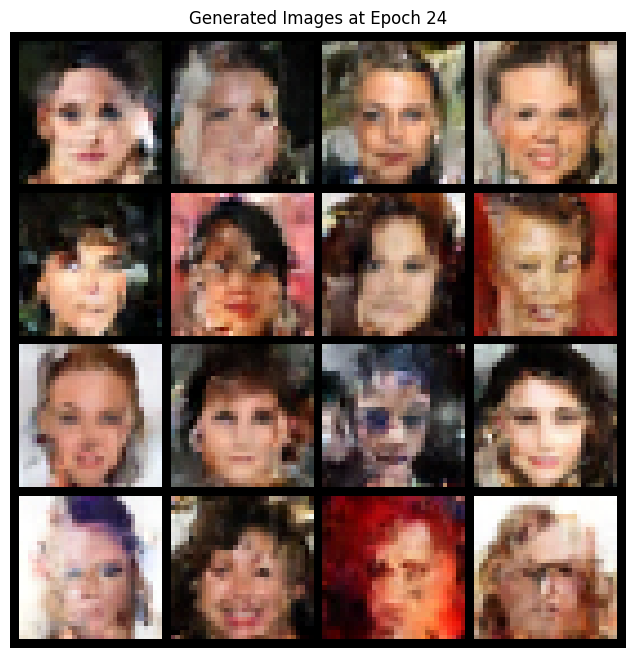

2025-06-22 04:57:53 - INFO - ------------------------------
2025-06-22 04:57:58 - INFO - Epoch: 25/60 | Batch: 0/318 | Loss (NLL): -8598.8809 | BPD: 3.9617
2025-06-22 05:00:20 - INFO - Epoch: 25/60 | Batch: 50/318 | Loss (NLL): -8747.0410 | BPD: 3.8922
2025-06-22 05:02:42 - INFO - Epoch: 25/60 | Batch: 100/318 | Loss (NLL): -8711.6924 | BPD: 3.9088
2025-06-22 05:05:03 - INFO - Epoch: 25/60 | Batch: 150/318 | Loss (NLL): -8785.6387 | BPD: 3.8740
2025-06-22 05:07:25 - INFO - Epoch: 25/60 | Batch: 200/318 | Loss (NLL): -8617.6123 | BPD: 3.9529
2025-06-22 05:09:47 - INFO - Epoch: 25/60 | Batch: 250/318 | Loss (NLL): -8603.4922 | BPD: 3.9596
2025-06-22 05:12:07 - INFO - Epoch: 25/60 | Batch: 300/318 | Loss (NLL): -8690.4648 | BPD: 3.9187
2025-06-22 05:12:55 - INFO - --- Epoch 25 Summary ---
2025-06-22 05:12:55 - INFO - Average Loss: -8691.2168 | Time: 901.97s
2025-06-22 05:12:55 - INFO - Generating sample images...


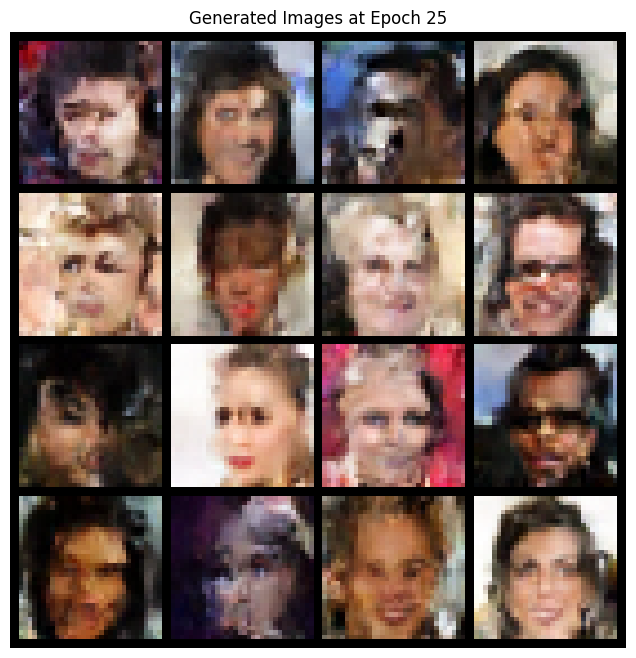

2025-06-22 05:12:56 - INFO - ------------------------------
2025-06-22 05:13:01 - INFO - Epoch: 26/60 | Batch: 0/318 | Loss (NLL): -8662.3779 | BPD: 3.9319
2025-06-22 05:15:23 - INFO - Epoch: 26/60 | Batch: 50/318 | Loss (NLL): -8764.3516 | BPD: 3.8840
2025-06-22 05:17:45 - INFO - Epoch: 26/60 | Batch: 100/318 | Loss (NLL): -8633.0059 | BPD: 3.9457
2025-06-22 05:20:07 - INFO - Epoch: 26/60 | Batch: 150/318 | Loss (NLL): -8772.1367 | BPD: 3.8804
2025-06-22 05:22:29 - INFO - Epoch: 26/60 | Batch: 200/318 | Loss (NLL): -8696.8838 | BPD: 3.9157
2025-06-22 05:24:51 - INFO - Epoch: 26/60 | Batch: 250/318 | Loss (NLL): -8664.4492 | BPD: 3.9309
2025-06-22 05:27:13 - INFO - Epoch: 26/60 | Batch: 300/318 | Loss (NLL): -8731.4189 | BPD: 3.8995
2025-06-22 05:28:01 - INFO - --- Epoch 26 Summary ---
2025-06-22 05:28:01 - INFO - Average Loss: -8722.3769 | Time: 905.06s
2025-06-22 05:28:01 - INFO - Generating sample images...


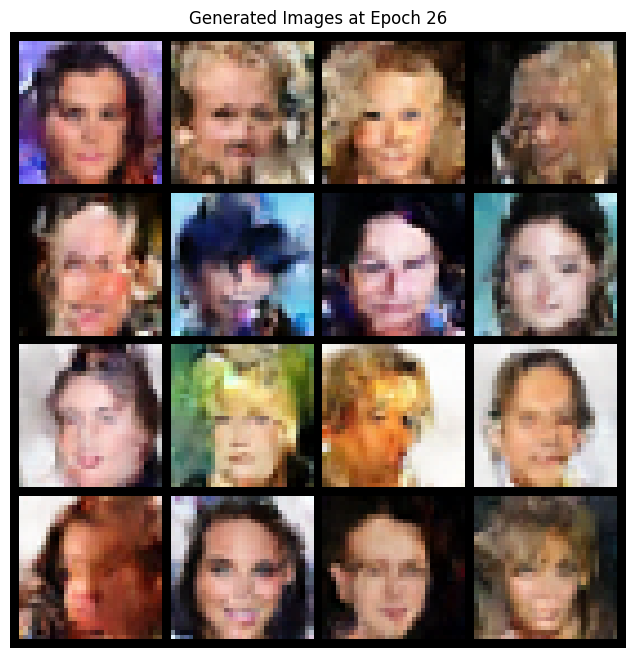

2025-06-22 05:28:02 - INFO - ------------------------------
2025-06-22 05:28:06 - INFO - Epoch: 27/60 | Batch: 0/318 | Loss (NLL): -8747.4336 | BPD: 3.8920
2025-06-22 05:30:28 - INFO - Epoch: 27/60 | Batch: 50/318 | Loss (NLL): -8720.1523 | BPD: 3.9048
2025-06-22 05:32:49 - INFO - Epoch: 27/60 | Batch: 100/318 | Loss (NLL): -8673.8242 | BPD: 3.9265
2025-06-22 05:35:11 - INFO - Epoch: 27/60 | Batch: 150/318 | Loss (NLL): -8677.8711 | BPD: 3.9246
2025-06-22 05:37:32 - INFO - Epoch: 27/60 | Batch: 200/318 | Loss (NLL): -8761.4453 | BPD: 3.8854
2025-06-22 05:39:54 - INFO - Epoch: 27/60 | Batch: 250/318 | Loss (NLL): -8693.2686 | BPD: 3.9174
2025-06-22 05:42:16 - INFO - Epoch: 27/60 | Batch: 300/318 | Loss (NLL): -8673.1465 | BPD: 3.9269
2025-06-22 05:43:04 - INFO - --- Epoch 27 Summary ---
2025-06-22 05:43:04 - INFO - Average Loss: -8711.5726 | Time: 902.17s
2025-06-22 05:43:04 - INFO - Generating sample images...


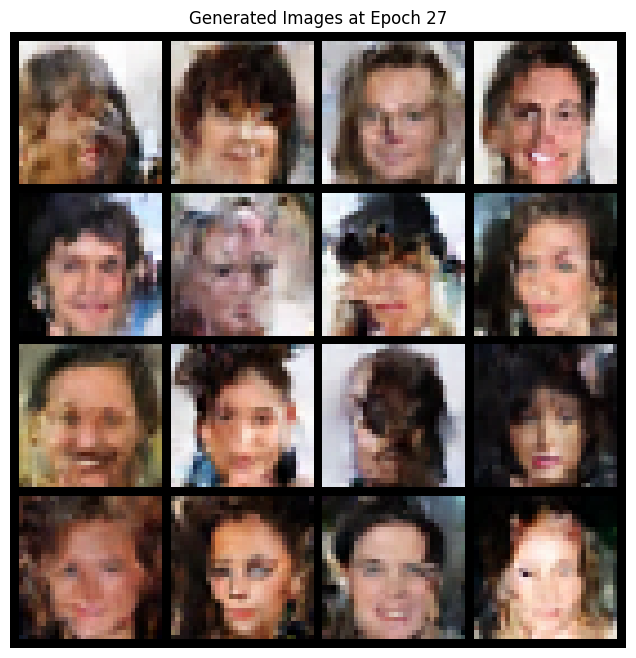

2025-06-22 05:43:04 - INFO - ------------------------------
2025-06-22 05:43:09 - INFO - Epoch: 28/60 | Batch: 0/318 | Loss (NLL): -8756.4248 | BPD: 3.8877
2025-06-22 05:45:31 - INFO - Epoch: 28/60 | Batch: 50/318 | Loss (NLL): -8734.0879 | BPD: 3.8982
2025-06-22 05:47:53 - INFO - Epoch: 28/60 | Batch: 100/318 | Loss (NLL): -8749.9219 | BPD: 3.8908
2025-06-22 05:50:14 - INFO - Epoch: 28/60 | Batch: 150/318 | Loss (NLL): -8736.4121 | BPD: 3.8971
2025-06-22 05:52:36 - INFO - Epoch: 28/60 | Batch: 200/318 | Loss (NLL): -8765.1738 | BPD: 3.8836
2025-06-22 05:54:58 - INFO - Epoch: 28/60 | Batch: 250/318 | Loss (NLL): -8724.6494 | BPD: 3.9027
2025-06-22 05:57:21 - INFO - Epoch: 28/60 | Batch: 300/318 | Loss (NLL): -8825.9307 | BPD: 3.8551
2025-06-22 05:58:09 - INFO - --- Epoch 28 Summary ---
2025-06-22 05:58:09 - INFO - Average Loss: -8753.7072 | Time: 904.78s
2025-06-22 05:58:09 - INFO - Generating sample images...


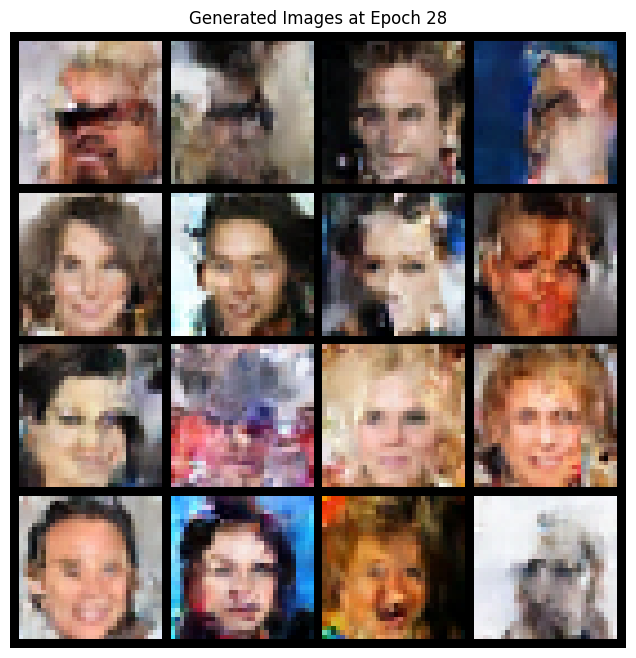

2025-06-22 05:58:09 - INFO - ------------------------------
2025-06-22 05:58:14 - INFO - Epoch: 29/60 | Batch: 0/318 | Loss (NLL): -8744.0684 | BPD: 3.8935
2025-06-22 06:00:37 - INFO - Epoch: 29/60 | Batch: 50/318 | Loss (NLL): -8758.1719 | BPD: 3.8869
2025-06-22 06:02:59 - INFO - Epoch: 29/60 | Batch: 100/318 | Loss (NLL): -8751.7715 | BPD: 3.8899
2025-06-22 06:05:22 - INFO - Epoch: 29/60 | Batch: 150/318 | Loss (NLL): -8742.3809 | BPD: 3.8943
2025-06-22 06:07:43 - INFO - Epoch: 29/60 | Batch: 200/318 | Loss (NLL): -8761.0068 | BPD: 3.8856
2025-06-22 06:10:05 - INFO - Epoch: 29/60 | Batch: 250/318 | Loss (NLL): -8839.8086 | BPD: 3.8486
2025-06-22 06:12:27 - INFO - Epoch: 29/60 | Batch: 300/318 | Loss (NLL): -8804.1719 | BPD: 3.8653
2025-06-22 06:13:15 - INFO - --- Epoch 29 Summary ---
2025-06-22 06:13:15 - INFO - Average Loss: -8757.2393 | Time: 905.88s
2025-06-22 06:13:15 - INFO - Generating sample images...


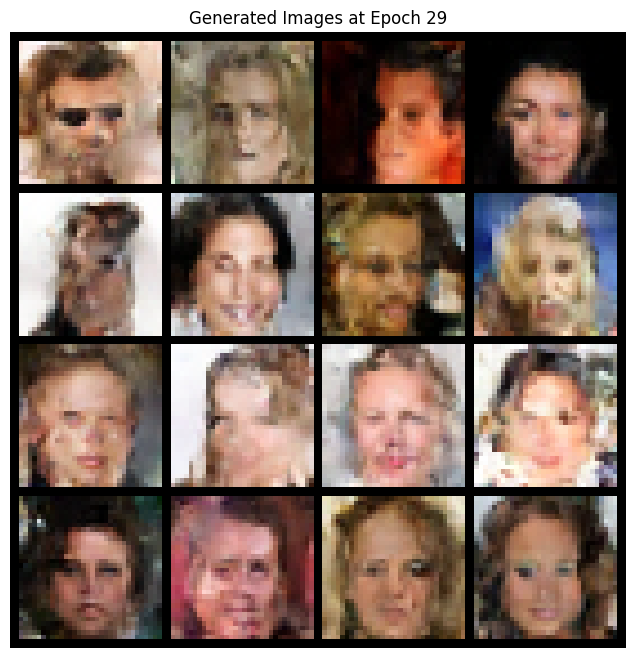

2025-06-22 06:13:16 - INFO - ------------------------------
2025-06-22 06:13:21 - INFO - Epoch: 30/60 | Batch: 0/318 | Loss (NLL): -8762.4082 | BPD: 3.8849
2025-06-22 06:15:43 - INFO - Epoch: 30/60 | Batch: 50/318 | Loss (NLL): -8811.8467 | BPD: 3.8617
2025-06-22 06:18:05 - INFO - Epoch: 30/60 | Batch: 100/318 | Loss (NLL): -8728.0820 | BPD: 3.9011
2025-06-22 06:20:27 - INFO - Epoch: 30/60 | Batch: 150/318 | Loss (NLL): -8860.1387 | BPD: 3.8390
2025-06-22 06:22:49 - INFO - Epoch: 30/60 | Batch: 200/318 | Loss (NLL): -8758.9629 | BPD: 3.8866
2025-06-22 06:25:11 - INFO - Epoch: 30/60 | Batch: 250/318 | Loss (NLL): -8688.4131 | BPD: 3.9197
2025-06-22 06:27:33 - INFO - Epoch: 30/60 | Batch: 300/318 | Loss (NLL): -8773.3643 | BPD: 3.8798
2025-06-22 06:28:21 - INFO - --- Epoch 30 Summary ---
2025-06-22 06:28:21 - INFO - Average Loss: -8774.1396 | Time: 905.20s
2025-06-22 06:28:21 - INFO - Generating sample images...


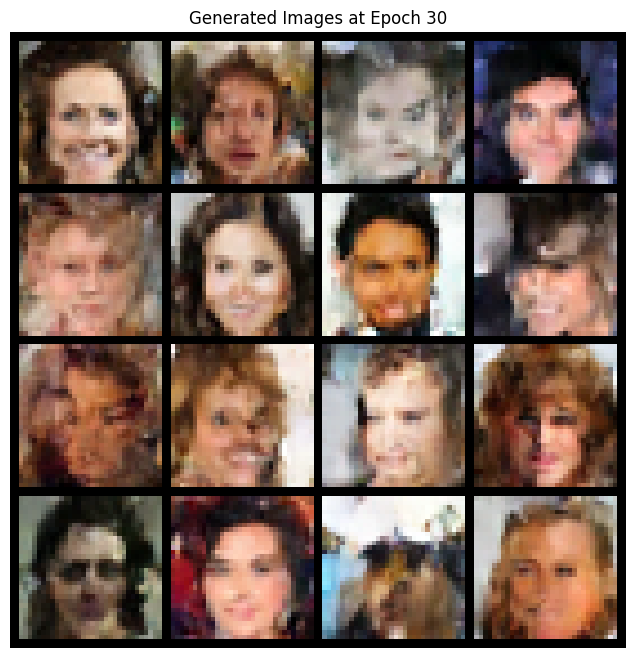

2025-06-22 06:28:22 - INFO - ------------------------------
2025-06-22 06:28:26 - INFO - Epoch: 31/60 | Batch: 0/318 | Loss (NLL): -8705.2100 | BPD: 3.9118
2025-06-22 06:30:48 - INFO - Epoch: 31/60 | Batch: 50/318 | Loss (NLL): -8766.3906 | BPD: 3.8831
2025-06-22 06:33:11 - INFO - Epoch: 31/60 | Batch: 100/318 | Loss (NLL): -8758.3652 | BPD: 3.8868
2025-06-22 06:35:32 - INFO - Epoch: 31/60 | Batch: 150/318 | Loss (NLL): -8817.6992 | BPD: 3.8590
2025-06-22 06:37:55 - INFO - Epoch: 31/60 | Batch: 200/318 | Loss (NLL): -8719.3125 | BPD: 3.9052
2025-06-22 06:40:17 - INFO - Epoch: 31/60 | Batch: 250/318 | Loss (NLL): -8715.5811 | BPD: 3.9069
2025-06-22 06:42:39 - INFO - Epoch: 31/60 | Batch: 300/318 | Loss (NLL): -8702.9434 | BPD: 3.9129
2025-06-22 06:43:27 - INFO - --- Epoch 31 Summary ---
2025-06-22 06:43:27 - INFO - Average Loss: -8775.5294 | Time: 905.66s
2025-06-22 06:43:27 - INFO - Generating sample images...


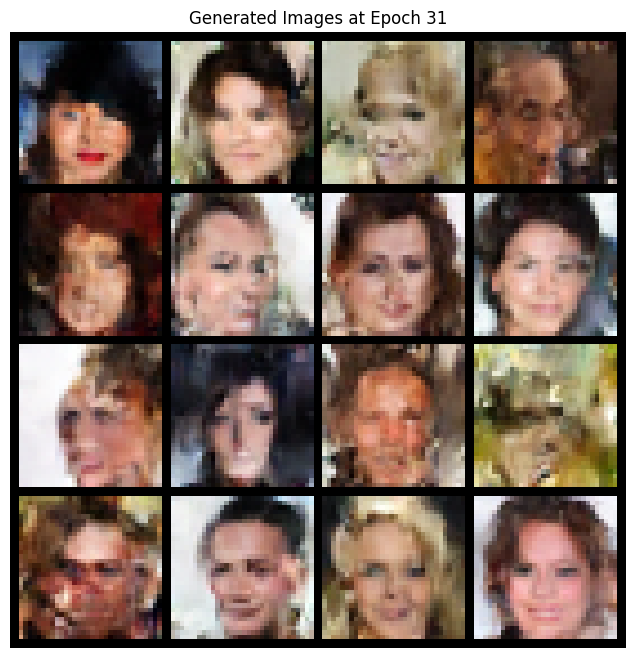

2025-06-22 06:43:28 - INFO - ------------------------------
2025-06-22 06:43:32 - INFO - Epoch: 32/60 | Batch: 0/318 | Loss (NLL): -8817.6387 | BPD: 3.8590
2025-06-22 06:45:54 - INFO - Epoch: 32/60 | Batch: 50/318 | Loss (NLL): -8699.8730 | BPD: 3.9143
2025-06-22 06:48:16 - INFO - Epoch: 32/60 | Batch: 100/318 | Loss (NLL): -8690.1523 | BPD: 3.9189
2025-06-22 06:50:38 - INFO - Epoch: 32/60 | Batch: 150/318 | Loss (NLL): -8755.1484 | BPD: 3.8883
2025-06-22 06:53:00 - INFO - Epoch: 32/60 | Batch: 200/318 | Loss (NLL): -8770.0254 | BPD: 3.8814
2025-06-22 06:55:22 - INFO - Epoch: 32/60 | Batch: 250/318 | Loss (NLL): -8771.7090 | BPD: 3.8806
2025-06-22 06:57:43 - INFO - Epoch: 32/60 | Batch: 300/318 | Loss (NLL): -8867.6426 | BPD: 3.8355
2025-06-22 06:58:31 - INFO - --- Epoch 32 Summary ---
2025-06-22 06:58:31 - INFO - Average Loss: -8788.9889 | Time: 903.74s
2025-06-22 06:58:31 - INFO - Generating sample images...


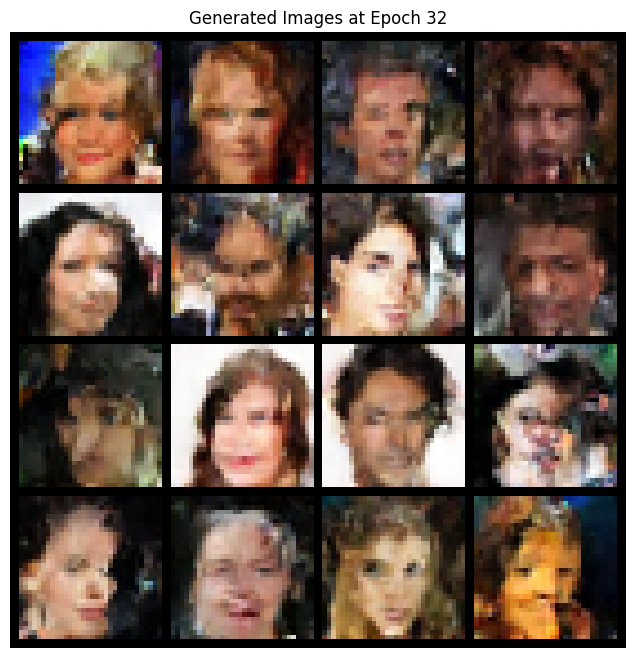

2025-06-22 06:58:32 - INFO - ------------------------------
2025-06-22 06:58:37 - INFO - Epoch: 33/60 | Batch: 0/318 | Loss (NLL): -8742.0615 | BPD: 3.8945
2025-06-22 07:00:59 - INFO - Epoch: 33/60 | Batch: 50/318 | Loss (NLL): -8691.6328 | BPD: 3.9182
2025-06-22 07:03:21 - INFO - Epoch: 33/60 | Batch: 100/318 | Loss (NLL): -8566.1406 | BPD: 3.9771
2025-06-22 07:05:43 - INFO - Epoch: 33/60 | Batch: 150/318 | Loss (NLL): -8888.7471 | BPD: 3.8256
2025-06-22 07:08:05 - INFO - Epoch: 33/60 | Batch: 200/318 | Loss (NLL): -8871.6113 | BPD: 3.8336
2025-06-22 07:10:27 - INFO - Epoch: 33/60 | Batch: 250/318 | Loss (NLL): -8779.1406 | BPD: 3.8771
2025-06-22 07:12:49 - INFO - Epoch: 33/60 | Batch: 300/318 | Loss (NLL): -8755.3096 | BPD: 3.8883
2025-06-22 07:13:37 - INFO - --- Epoch 33 Summary ---
2025-06-22 07:13:37 - INFO - Average Loss: -8797.1572 | Time: 904.92s
2025-06-22 07:13:37 - INFO - Generating sample images...


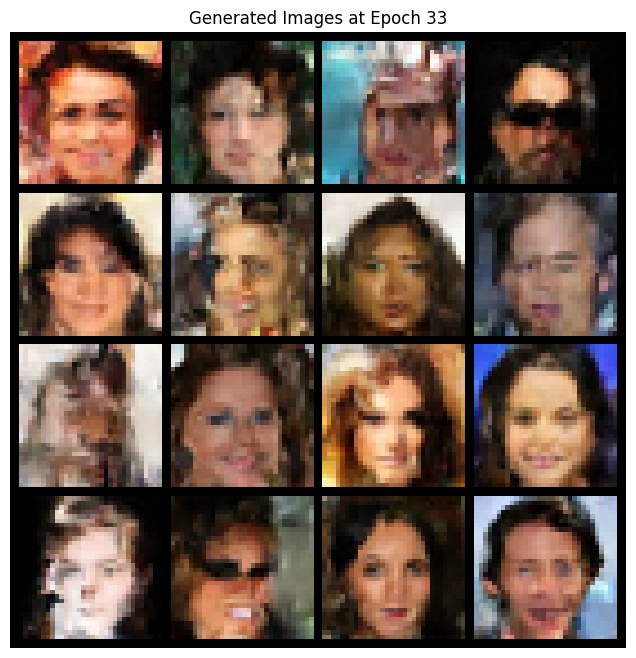

2025-06-22 07:13:37 - INFO - ------------------------------
2025-06-22 07:13:42 - INFO - Epoch: 34/60 | Batch: 0/318 | Loss (NLL): -8846.4941 | BPD: 3.8454
2025-06-22 07:16:04 - INFO - Epoch: 34/60 | Batch: 50/318 | Loss (NLL): -8806.9375 | BPD: 3.8640
2025-06-22 07:18:27 - INFO - Epoch: 34/60 | Batch: 100/318 | Loss (NLL): -8750.4121 | BPD: 3.8906
2025-06-22 07:20:49 - INFO - Epoch: 34/60 | Batch: 150/318 | Loss (NLL): -8812.9570 | BPD: 3.8612
2025-06-22 07:23:12 - INFO - Epoch: 34/60 | Batch: 200/318 | Loss (NLL): -8808.6650 | BPD: 3.8632
2025-06-22 07:25:34 - INFO - Epoch: 34/60 | Batch: 250/318 | Loss (NLL): -8788.9189 | BPD: 3.8725
2025-06-22 07:27:56 - INFO - Epoch: 34/60 | Batch: 300/318 | Loss (NLL): -8832.7578 | BPD: 3.8519
2025-06-22 07:28:44 - INFO - --- Epoch 34 Summary ---
2025-06-22 07:28:44 - INFO - Average Loss: -8827.9536 | Time: 906.64s
2025-06-22 07:28:44 - INFO - Generating sample images...


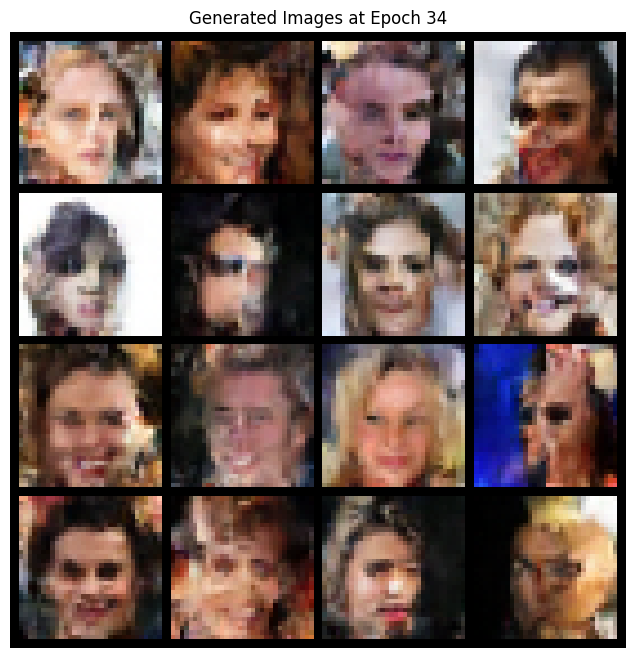

2025-06-22 07:28:45 - INFO - ------------------------------
2025-06-22 07:28:49 - INFO - Epoch: 35/60 | Batch: 0/318 | Loss (NLL): -8811.2090 | BPD: 3.8620
2025-06-22 07:31:11 - INFO - Epoch: 35/60 | Batch: 50/318 | Loss (NLL): -8849.3418 | BPD: 3.8441
2025-06-22 07:33:33 - INFO - Epoch: 35/60 | Batch: 100/318 | Loss (NLL): -8809.6621 | BPD: 3.8627
2025-06-22 07:35:55 - INFO - Epoch: 35/60 | Batch: 150/318 | Loss (NLL): -8880.1836 | BPD: 3.8296
2025-06-22 07:38:18 - INFO - Epoch: 35/60 | Batch: 200/318 | Loss (NLL): -8795.5449 | BPD: 3.8694
2025-06-22 07:40:40 - INFO - Epoch: 35/60 | Batch: 250/318 | Loss (NLL): -8867.6211 | BPD: 3.8355
2025-06-22 07:43:02 - INFO - Epoch: 35/60 | Batch: 300/318 | Loss (NLL): -8842.7744 | BPD: 3.8472
2025-06-22 07:43:51 - INFO - --- Epoch 35 Summary ---
2025-06-22 07:43:51 - INFO - Average Loss: -8829.6797 | Time: 906.30s
2025-06-22 07:43:51 - INFO - Generating sample images...


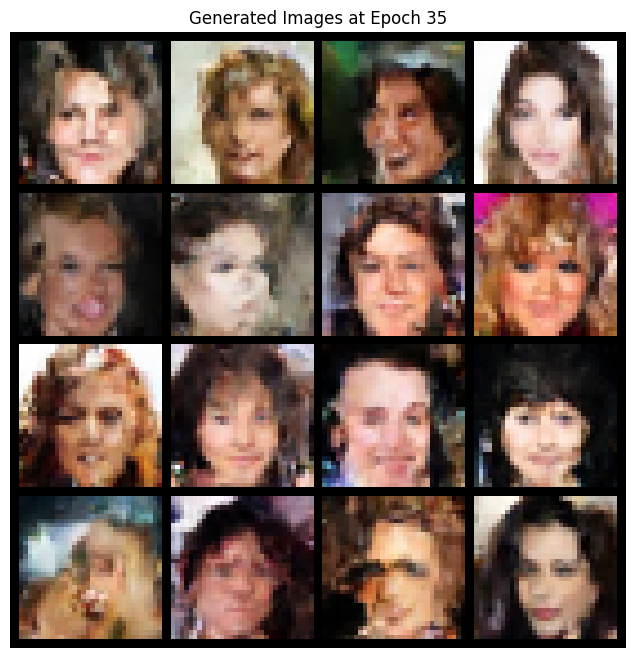

2025-06-22 07:43:51 - INFO - ------------------------------
2025-06-22 07:43:56 - INFO - Epoch: 36/60 | Batch: 0/318 | Loss (NLL): -8872.0986 | BPD: 3.8334
2025-06-22 07:46:18 - INFO - Epoch: 36/60 | Batch: 50/318 | Loss (NLL): -8810.2031 | BPD: 3.8625
2025-06-22 07:48:40 - INFO - Epoch: 36/60 | Batch: 100/318 | Loss (NLL): -8848.7539 | BPD: 3.8444
2025-06-22 07:51:02 - INFO - Epoch: 36/60 | Batch: 150/318 | Loss (NLL): -8819.5957 | BPD: 3.8581
2025-06-22 07:53:24 - INFO - Epoch: 36/60 | Batch: 200/318 | Loss (NLL): -8811.5371 | BPD: 3.8619
2025-06-22 07:55:46 - INFO - Epoch: 36/60 | Batch: 250/318 | Loss (NLL): -8795.7227 | BPD: 3.8693
2025-06-22 07:58:08 - INFO - Epoch: 36/60 | Batch: 300/318 | Loss (NLL): -8829.0000 | BPD: 3.8537
2025-06-22 07:58:56 - INFO - --- Epoch 36 Summary ---
2025-06-22 07:58:57 - INFO - Average Loss: -8841.3269 | Time: 905.17s
2025-06-22 07:58:57 - INFO - Generating sample images...


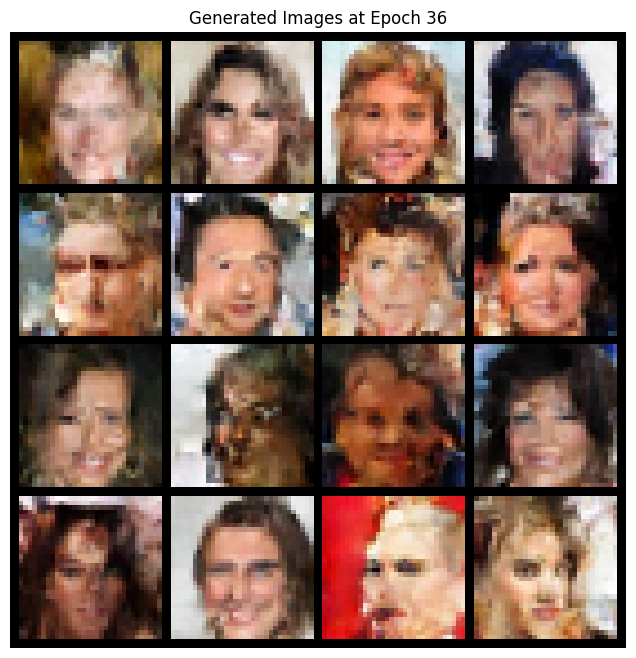

2025-06-22 07:58:57 - INFO - ------------------------------
2025-06-22 07:59:02 - INFO - Epoch: 37/60 | Batch: 0/318 | Loss (NLL): -8799.3086 | BPD: 3.8676
2025-06-22 08:01:23 - INFO - Epoch: 37/60 | Batch: 50/318 | Loss (NLL): -8892.2148 | BPD: 3.8240
2025-06-22 08:03:45 - INFO - Epoch: 37/60 | Batch: 100/318 | Loss (NLL): -8775.0479 | BPD: 3.8790
2025-06-22 08:06:07 - INFO - Epoch: 37/60 | Batch: 150/318 | Loss (NLL): -8821.6797 | BPD: 3.8571
2025-06-22 08:08:29 - INFO - Epoch: 37/60 | Batch: 200/318 | Loss (NLL): -8762.1143 | BPD: 3.8851
2025-06-22 08:10:52 - INFO - Epoch: 37/60 | Batch: 250/318 | Loss (NLL): -8924.8213 | BPD: 3.8087
2025-06-22 08:13:14 - INFO - Epoch: 37/60 | Batch: 300/318 | Loss (NLL): -8844.4570 | BPD: 3.8464
2025-06-22 08:14:03 - INFO - --- Epoch 37 Summary ---
2025-06-22 08:14:03 - INFO - Average Loss: -8852.2215 | Time: 905.61s
2025-06-22 08:14:03 - INFO - Generating sample images...


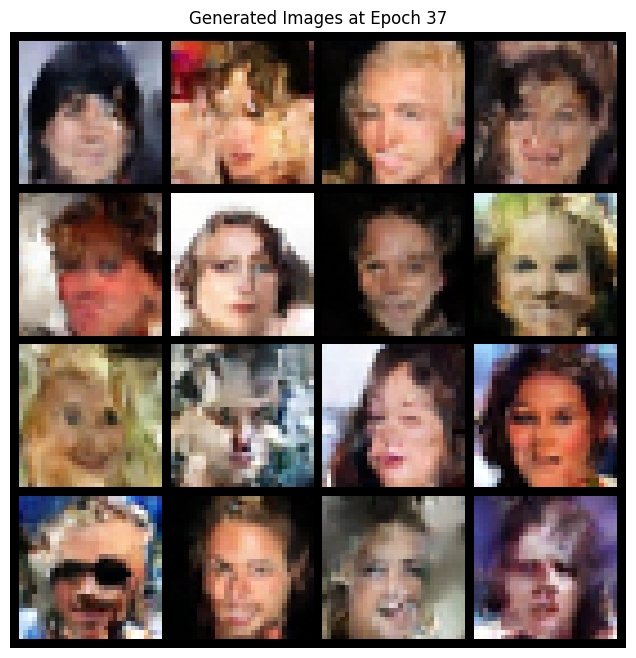

2025-06-22 08:14:03 - INFO - ------------------------------
2025-06-22 08:14:08 - INFO - Epoch: 38/60 | Batch: 0/318 | Loss (NLL): -8898.5078 | BPD: 3.8210
2025-06-22 08:16:30 - INFO - Epoch: 38/60 | Batch: 50/318 | Loss (NLL): -8804.6250 | BPD: 3.8651
2025-06-22 08:18:53 - INFO - Epoch: 38/60 | Batch: 100/318 | Loss (NLL): -8913.4336 | BPD: 3.8140
2025-06-22 08:21:16 - INFO - Epoch: 38/60 | Batch: 150/318 | Loss (NLL): -8734.2402 | BPD: 3.8982
2025-06-22 08:23:38 - INFO - Epoch: 38/60 | Batch: 200/318 | Loss (NLL): -8874.3408 | BPD: 3.8324
2025-06-22 08:26:00 - INFO - Epoch: 38/60 | Batch: 250/318 | Loss (NLL): -8801.4297 | BPD: 3.8666
2025-06-22 08:28:22 - INFO - Epoch: 38/60 | Batch: 300/318 | Loss (NLL): -8856.8594 | BPD: 3.8406
2025-06-22 08:29:10 - INFO - --- Epoch 38 Summary ---
2025-06-22 08:29:10 - INFO - Average Loss: -8864.2983 | Time: 906.93s
2025-06-22 08:29:10 - INFO - Generating sample images...


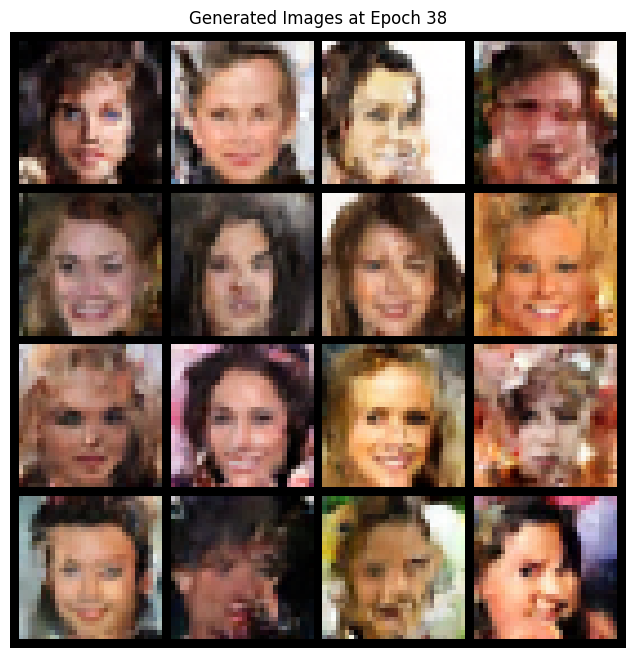

2025-06-22 08:29:11 - INFO - ------------------------------
2025-06-22 08:29:15 - INFO - Epoch: 39/60 | Batch: 0/318 | Loss (NLL): -8913.3535 | BPD: 3.8140
2025-06-22 08:31:37 - INFO - Epoch: 39/60 | Batch: 50/318 | Loss (NLL): -8893.9688 | BPD: 3.8231
2025-06-22 08:33:59 - INFO - Epoch: 39/60 | Batch: 100/318 | Loss (NLL): -8844.7734 | BPD: 3.8463
2025-06-22 08:36:21 - INFO - Epoch: 39/60 | Batch: 150/318 | Loss (NLL): -8905.0664 | BPD: 3.8179
2025-06-22 08:38:43 - INFO - Epoch: 39/60 | Batch: 200/318 | Loss (NLL): -8946.2207 | BPD: 3.7986
2025-06-22 08:41:06 - INFO - Epoch: 39/60 | Batch: 250/318 | Loss (NLL): -8886.7207 | BPD: 3.8266
2025-06-22 08:43:27 - INFO - Epoch: 39/60 | Batch: 300/318 | Loss (NLL): -8787.7441 | BPD: 3.8730
2025-06-22 08:44:15 - INFO - --- Epoch 39 Summary ---
2025-06-22 08:44:15 - INFO - Average Loss: -8881.3290 | Time: 904.67s
2025-06-22 08:44:15 - INFO - Generating sample images...


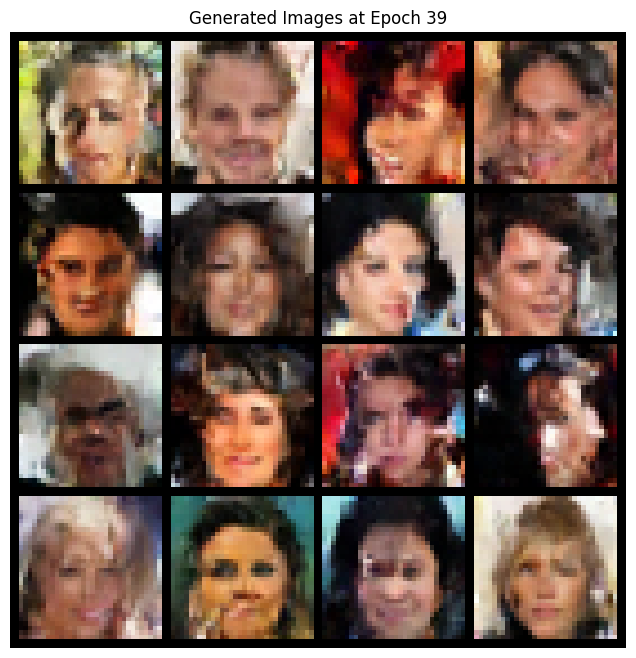

2025-06-22 08:44:16 - INFO - ------------------------------
2025-06-22 08:44:20 - INFO - Epoch: 40/60 | Batch: 0/318 | Loss (NLL): -8786.5352 | BPD: 3.8736
2025-06-22 08:46:42 - INFO - Epoch: 40/60 | Batch: 50/318 | Loss (NLL): -8798.7061 | BPD: 3.8679
2025-06-22 08:49:04 - INFO - Epoch: 40/60 | Batch: 100/318 | Loss (NLL): -8832.0312 | BPD: 3.8522
2025-06-22 08:51:26 - INFO - Epoch: 40/60 | Batch: 150/318 | Loss (NLL): -8973.0039 | BPD: 3.7860
2025-06-22 08:53:48 - INFO - Epoch: 40/60 | Batch: 200/318 | Loss (NLL): -8898.4463 | BPD: 3.8210
2025-06-22 08:56:11 - INFO - Epoch: 40/60 | Batch: 250/318 | Loss (NLL): -8824.3184 | BPD: 3.8559
2025-06-22 08:58:33 - INFO - Epoch: 40/60 | Batch: 300/318 | Loss (NLL): -8860.5439 | BPD: 3.8388
2025-06-22 08:59:21 - INFO - --- Epoch 40 Summary ---
2025-06-22 08:59:21 - INFO - Average Loss: -8881.2112 | Time: 905.41s
2025-06-22 08:59:21 - INFO - Generating sample images...


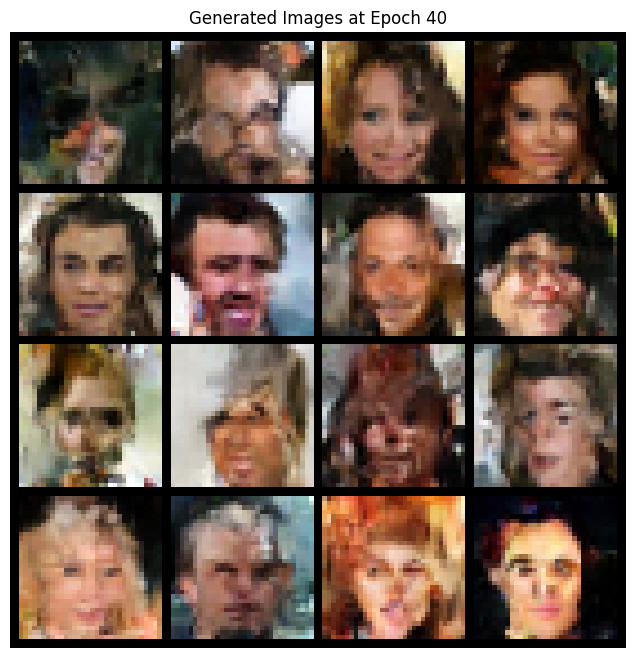

2025-06-22 08:59:22 - INFO - ------------------------------
2025-06-22 08:59:26 - INFO - Epoch: 41/60 | Batch: 0/318 | Loss (NLL): -8863.7871 | BPD: 3.8373
2025-06-22 09:01:49 - INFO - Epoch: 41/60 | Batch: 50/318 | Loss (NLL): -8938.9512 | BPD: 3.8020
2025-06-22 09:04:12 - INFO - Epoch: 41/60 | Batch: 100/318 | Loss (NLL): -8921.1055 | BPD: 3.8104
2025-06-22 09:06:34 - INFO - Epoch: 41/60 | Batch: 150/318 | Loss (NLL): -8997.2871 | BPD: 3.7746
2025-06-22 09:08:58 - INFO - Epoch: 41/60 | Batch: 200/318 | Loss (NLL): -8956.1660 | BPD: 3.7939
2025-06-22 09:11:23 - INFO - Epoch: 41/60 | Batch: 250/318 | Loss (NLL): -8924.7969 | BPD: 3.8087
2025-06-22 09:13:49 - INFO - Epoch: 41/60 | Batch: 300/318 | Loss (NLL): -8869.9053 | BPD: 3.8345
2025-06-22 09:14:38 - INFO - --- Epoch 41 Summary ---
2025-06-22 09:14:38 - INFO - Average Loss: -8891.5216 | Time: 916.02s
2025-06-22 09:14:38 - INFO - Generating sample images...


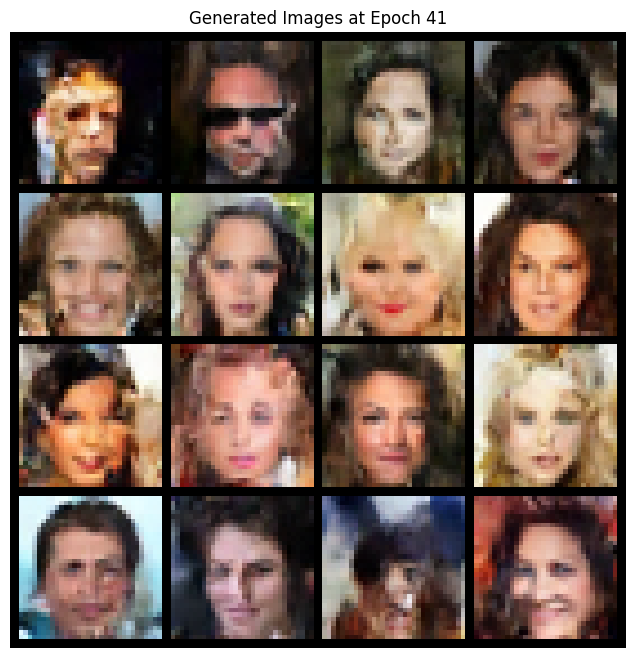

2025-06-22 09:14:38 - INFO - ------------------------------
2025-06-22 09:14:43 - INFO - Epoch: 42/60 | Batch: 0/318 | Loss (NLL): -8985.3389 | BPD: 3.7802
2025-06-22 09:17:05 - INFO - Epoch: 42/60 | Batch: 50/318 | Loss (NLL): -8970.0557 | BPD: 3.7874
2025-06-22 09:19:28 - INFO - Epoch: 42/60 | Batch: 100/318 | Loss (NLL): -8898.4121 | BPD: 3.8211
2025-06-22 09:21:50 - INFO - Epoch: 42/60 | Batch: 150/318 | Loss (NLL): -8923.0244 | BPD: 3.8095
2025-06-22 09:24:13 - INFO - Epoch: 42/60 | Batch: 200/318 | Loss (NLL): -8849.8164 | BPD: 3.8439
2025-06-22 09:26:35 - INFO - Epoch: 42/60 | Batch: 250/318 | Loss (NLL): -8971.4170 | BPD: 3.7868
2025-06-22 09:28:57 - INFO - Epoch: 42/60 | Batch: 300/318 | Loss (NLL): -8929.3105 | BPD: 3.8066
2025-06-22 09:29:45 - INFO - --- Epoch 42 Summary ---
2025-06-22 09:29:45 - INFO - Average Loss: -8896.1946 | Time: 907.23s
2025-06-22 09:29:45 - INFO - Generating sample images...


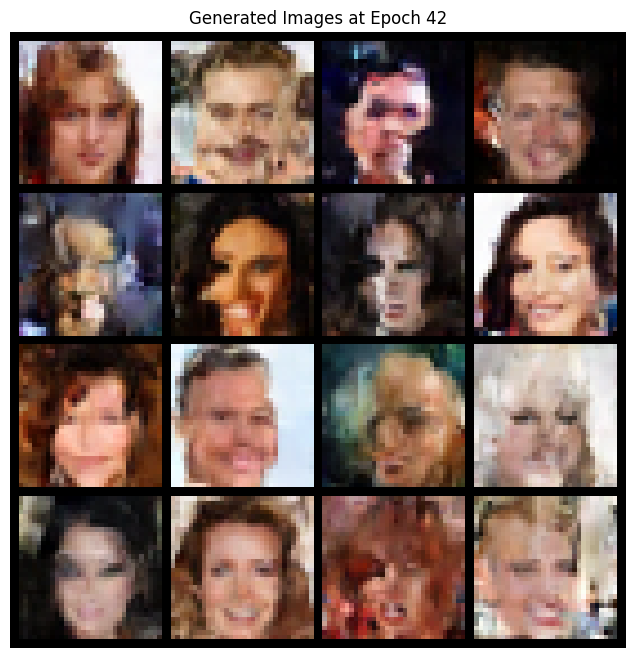

2025-06-22 09:29:46 - INFO - ------------------------------
2025-06-22 09:29:51 - INFO - Epoch: 43/60 | Batch: 0/318 | Loss (NLL): -8906.6357 | BPD: 3.8172
2025-06-22 09:32:13 - INFO - Epoch: 43/60 | Batch: 50/318 | Loss (NLL): -8890.1650 | BPD: 3.8249
2025-06-22 09:34:34 - INFO - Epoch: 43/60 | Batch: 100/318 | Loss (NLL): -8885.3594 | BPD: 3.8272
2025-06-22 09:36:55 - INFO - Epoch: 43/60 | Batch: 150/318 | Loss (NLL): -8966.7832 | BPD: 3.7890
2025-06-22 09:39:17 - INFO - Epoch: 43/60 | Batch: 200/318 | Loss (NLL): -9054.5859 | BPD: 3.7477
2025-06-22 09:41:40 - INFO - Epoch: 43/60 | Batch: 250/318 | Loss (NLL): -8890.7461 | BPD: 3.8247
2025-06-22 09:44:02 - INFO - Epoch: 43/60 | Batch: 300/318 | Loss (NLL): -8975.7803 | BPD: 3.7847
2025-06-22 09:44:50 - INFO - --- Epoch 43 Summary ---
2025-06-22 09:44:50 - INFO - Average Loss: -8914.2129 | Time: 903.91s
2025-06-22 09:44:50 - INFO - Generating sample images...


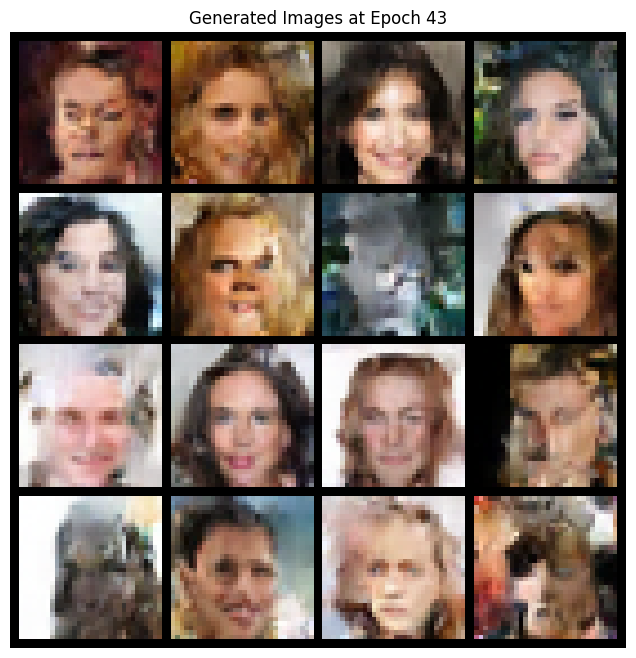

2025-06-22 09:44:50 - INFO - ------------------------------
2025-06-22 09:44:55 - INFO - Epoch: 44/60 | Batch: 0/318 | Loss (NLL): -8918.2705 | BPD: 3.8117
2025-06-22 09:47:20 - INFO - Epoch: 44/60 | Batch: 50/318 | Loss (NLL): -8897.6709 | BPD: 3.8214
2025-06-22 09:49:44 - INFO - Epoch: 44/60 | Batch: 100/318 | Loss (NLL): -8897.8682 | BPD: 3.8213
2025-06-22 09:52:08 - INFO - Epoch: 44/60 | Batch: 150/318 | Loss (NLL): -8909.5488 | BPD: 3.8158
2025-06-22 09:54:33 - INFO - Epoch: 44/60 | Batch: 200/318 | Loss (NLL): -8869.8965 | BPD: 3.8345
2025-06-22 09:56:56 - INFO - Epoch: 44/60 | Batch: 250/318 | Loss (NLL): -8896.6221 | BPD: 3.8219
2025-06-22 09:59:20 - INFO - Epoch: 44/60 | Batch: 300/318 | Loss (NLL): -8902.0908 | BPD: 3.8193
2025-06-22 10:00:09 - INFO - --- Epoch 44 Summary ---
2025-06-22 10:00:09 - INFO - Average Loss: -8913.3950 | Time: 918.94s
2025-06-22 10:00:09 - INFO - Generating sample images...


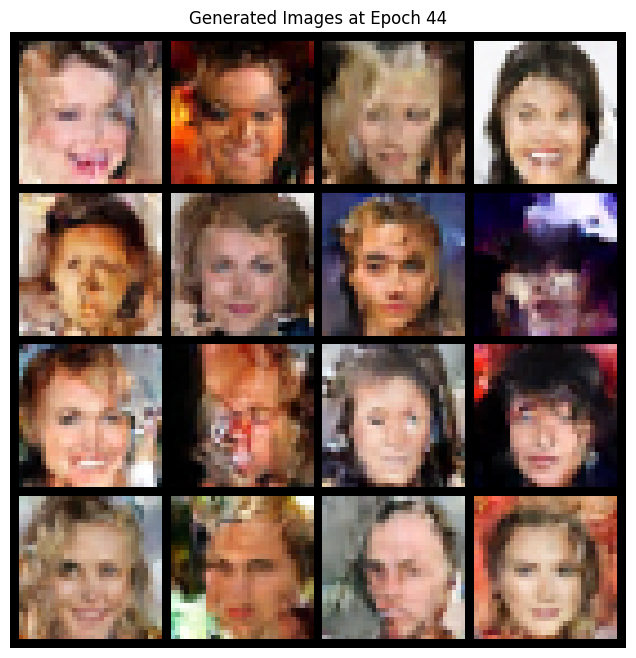

2025-06-22 10:00:10 - INFO - ------------------------------
2025-06-22 10:00:14 - INFO - Epoch: 45/60 | Batch: 0/318 | Loss (NLL): -9021.6016 | BPD: 3.7632
2025-06-22 10:02:37 - INFO - Epoch: 45/60 | Batch: 50/318 | Loss (NLL): -8978.4551 | BPD: 3.7835
2025-06-22 10:04:59 - INFO - Epoch: 45/60 | Batch: 100/318 | Loss (NLL): -8888.8574 | BPD: 3.8255
2025-06-22 10:07:22 - INFO - Epoch: 45/60 | Batch: 150/318 | Loss (NLL): -8885.2861 | BPD: 3.8272
2025-06-22 10:09:44 - INFO - Epoch: 45/60 | Batch: 200/318 | Loss (NLL): -8891.3545 | BPD: 3.8244
2025-06-22 10:12:06 - INFO - Epoch: 45/60 | Batch: 250/318 | Loss (NLL): -8770.3887 | BPD: 3.8812
2025-06-22 10:14:28 - INFO - Epoch: 45/60 | Batch: 300/318 | Loss (NLL): -8906.3438 | BPD: 3.8173
2025-06-22 10:15:16 - INFO - --- Epoch 45 Summary ---
2025-06-22 10:15:16 - INFO - Average Loss: -8910.6610 | Time: 906.33s
2025-06-22 10:15:16 - INFO - Generating sample images...


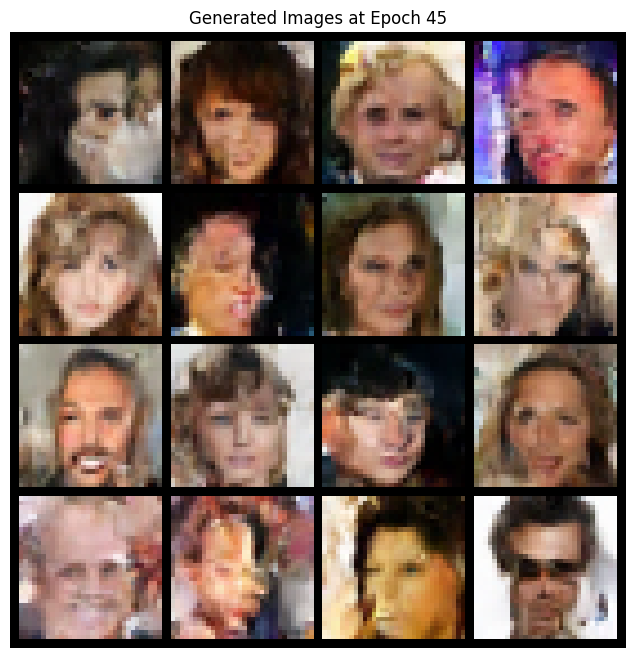

2025-06-22 10:15:17 - INFO - ------------------------------
2025-06-22 10:15:21 - INFO - Epoch: 46/60 | Batch: 0/318 | Loss (NLL): -8983.8281 | BPD: 3.7809
2025-06-22 10:17:45 - INFO - Epoch: 46/60 | Batch: 50/318 | Loss (NLL): -8966.3867 | BPD: 3.7891
2025-06-22 10:20:09 - INFO - Epoch: 46/60 | Batch: 100/318 | Loss (NLL): -8946.9375 | BPD: 3.7983
2025-06-22 10:22:32 - INFO - Epoch: 46/60 | Batch: 150/318 | Loss (NLL): -8897.8984 | BPD: 3.8213
2025-06-22 10:24:57 - INFO - Epoch: 46/60 | Batch: 200/318 | Loss (NLL): -9001.5312 | BPD: 3.7726
2025-06-22 10:27:19 - INFO - Epoch: 46/60 | Batch: 250/318 | Loss (NLL): -8882.9688 | BPD: 3.8283
2025-06-22 10:29:42 - INFO - Epoch: 46/60 | Batch: 300/318 | Loss (NLL): -8953.0312 | BPD: 3.7954
2025-06-22 10:30:30 - INFO - --- Epoch 46 Summary ---
2025-06-22 10:30:30 - INFO - Average Loss: -8939.5623 | Time: 913.10s
2025-06-22 10:30:30 - INFO - Generating sample images...


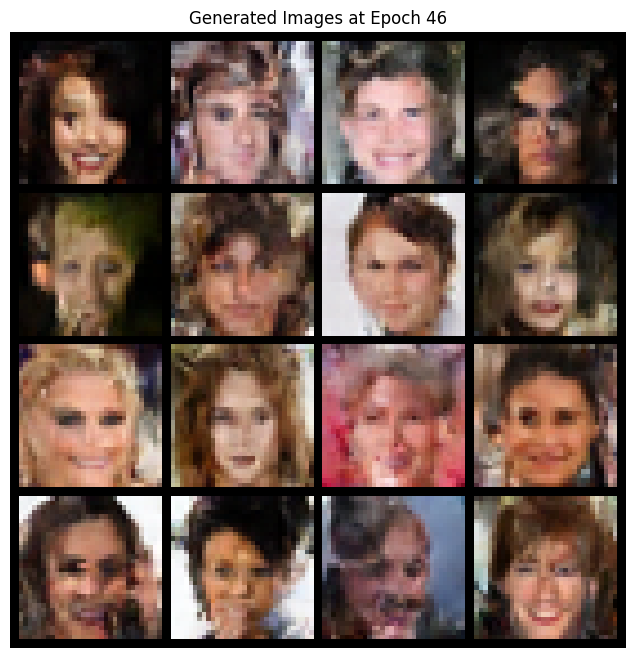

2025-06-22 10:30:30 - INFO - ------------------------------
2025-06-22 10:30:35 - INFO - Epoch: 47/60 | Batch: 0/318 | Loss (NLL): -8875.7910 | BPD: 3.8317
2025-06-22 10:32:56 - INFO - Epoch: 47/60 | Batch: 50/318 | Loss (NLL): -8962.5420 | BPD: 3.7909
2025-06-22 10:35:18 - INFO - Epoch: 47/60 | Batch: 100/318 | Loss (NLL): -8765.4648 | BPD: 3.8835
2025-06-22 10:37:40 - INFO - Epoch: 47/60 | Batch: 150/318 | Loss (NLL): -8870.9844 | BPD: 3.8339
2025-06-22 10:40:03 - INFO - Epoch: 47/60 | Batch: 200/318 | Loss (NLL): -8966.5605 | BPD: 3.7891
2025-06-22 10:42:25 - INFO - Epoch: 47/60 | Batch: 250/318 | Loss (NLL): -8892.8721 | BPD: 3.8237
2025-06-22 10:44:47 - INFO - Epoch: 47/60 | Batch: 300/318 | Loss (NLL): -8942.2422 | BPD: 3.8005
2025-06-22 10:45:35 - INFO - --- Epoch 47 Summary ---
2025-06-22 10:45:35 - INFO - Average Loss: -8941.6044 | Time: 904.95s
2025-06-22 10:45:35 - INFO - Generating sample images...


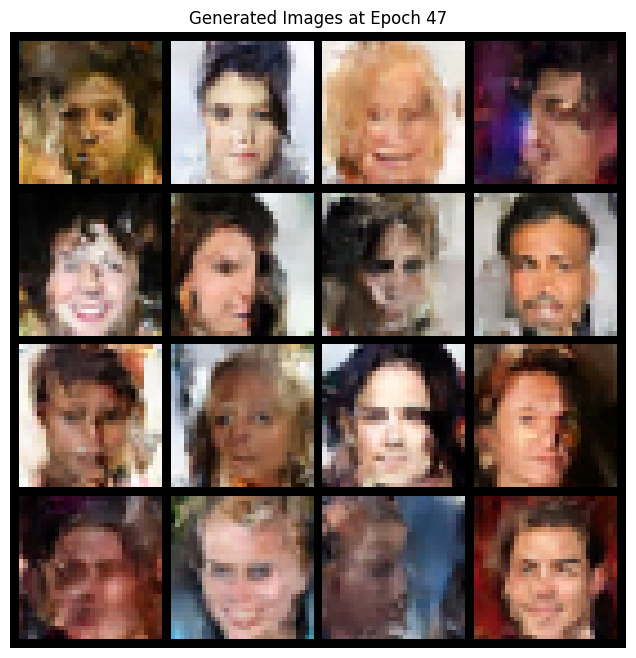

2025-06-22 10:45:36 - INFO - ------------------------------
2025-06-22 10:45:40 - INFO - Epoch: 48/60 | Batch: 0/318 | Loss (NLL): -8935.0039 | BPD: 3.8039
2025-06-22 10:48:02 - INFO - Epoch: 48/60 | Batch: 50/318 | Loss (NLL): -8962.1680 | BPD: 3.7911
2025-06-22 10:50:23 - INFO - Epoch: 48/60 | Batch: 100/318 | Loss (NLL): -9001.3701 | BPD: 3.7727
2025-06-22 10:52:46 - INFO - Epoch: 48/60 | Batch: 150/318 | Loss (NLL): -8971.4980 | BPD: 3.7867
2025-06-22 10:55:06 - INFO - Epoch: 48/60 | Batch: 200/318 | Loss (NLL): -8846.4102 | BPD: 3.8455
2025-06-22 10:57:29 - INFO - Epoch: 48/60 | Batch: 250/318 | Loss (NLL): -9043.9551 | BPD: 3.7527
2025-06-22 10:59:54 - INFO - Epoch: 48/60 | Batch: 300/318 | Loss (NLL): -9043.1992 | BPD: 3.7531
2025-06-22 11:00:43 - INFO - --- Epoch 48 Summary ---
2025-06-22 11:00:43 - INFO - Average Loss: -8939.6557 | Time: 907.31s
2025-06-22 11:00:43 - INFO - Generating sample images...


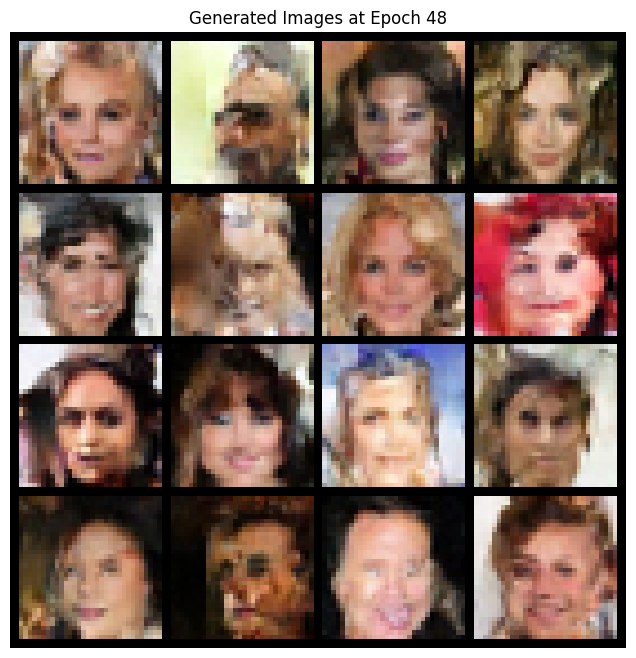

2025-06-22 11:00:43 - INFO - ------------------------------
2025-06-22 11:00:48 - INFO - Epoch: 49/60 | Batch: 0/318 | Loss (NLL): -8993.6455 | BPD: 3.7763
2025-06-22 11:03:12 - INFO - Epoch: 49/60 | Batch: 50/318 | Loss (NLL): -9015.5957 | BPD: 3.7660
2025-06-22 11:05:35 - INFO - Epoch: 49/60 | Batch: 100/318 | Loss (NLL): -8885.4355 | BPD: 3.8272
2025-06-22 11:07:57 - INFO - Epoch: 49/60 | Batch: 150/318 | Loss (NLL): -8810.3184 | BPD: 3.8624
2025-06-22 11:10:21 - INFO - Epoch: 49/60 | Batch: 200/318 | Loss (NLL): -8976.1240 | BPD: 3.7846
2025-06-22 11:12:47 - INFO - Epoch: 49/60 | Batch: 250/318 | Loss (NLL): -9018.6914 | BPD: 3.7646
2025-06-22 11:15:14 - INFO - Epoch: 49/60 | Batch: 300/318 | Loss (NLL): -8993.9346 | BPD: 3.7762
2025-06-22 11:16:04 - INFO - --- Epoch 49 Summary ---
2025-06-22 11:16:04 - INFO - Average Loss: -8949.1512 | Time: 920.06s
2025-06-22 11:16:04 - INFO - Generating sample images...


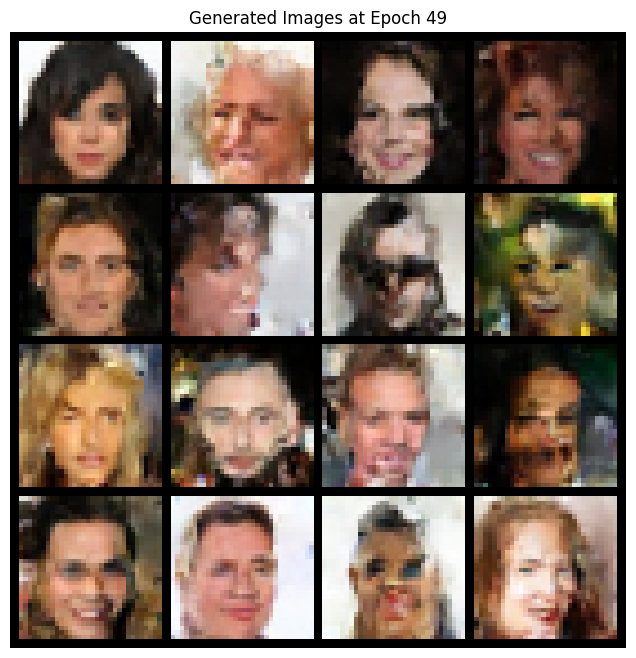

2025-06-22 11:16:04 - INFO - ------------------------------
2025-06-22 11:16:09 - INFO - Epoch: 50/60 | Batch: 0/318 | Loss (NLL): -8989.0293 | BPD: 3.7785
2025-06-22 11:18:35 - INFO - Epoch: 50/60 | Batch: 50/318 | Loss (NLL): -8983.9033 | BPD: 3.7809
2025-06-22 11:21:00 - INFO - Epoch: 50/60 | Batch: 100/318 | Loss (NLL): -8924.3398 | BPD: 3.8089
2025-06-22 11:23:22 - INFO - Epoch: 50/60 | Batch: 150/318 | Loss (NLL): -8968.4756 | BPD: 3.7882
2025-06-22 11:25:44 - INFO - Epoch: 50/60 | Batch: 200/318 | Loss (NLL): -8925.1035 | BPD: 3.8085
2025-06-22 11:28:05 - INFO - Epoch: 50/60 | Batch: 250/318 | Loss (NLL): -8948.3770 | BPD: 3.7976
2025-06-22 11:30:28 - INFO - Epoch: 50/60 | Batch: 300/318 | Loss (NLL): -9007.2109 | BPD: 3.7700
2025-06-22 11:31:16 - INFO - --- Epoch 50 Summary ---
2025-06-22 11:31:16 - INFO - Average Loss: -8955.2431 | Time: 911.65s
2025-06-22 11:31:16 - INFO - Generating sample images...


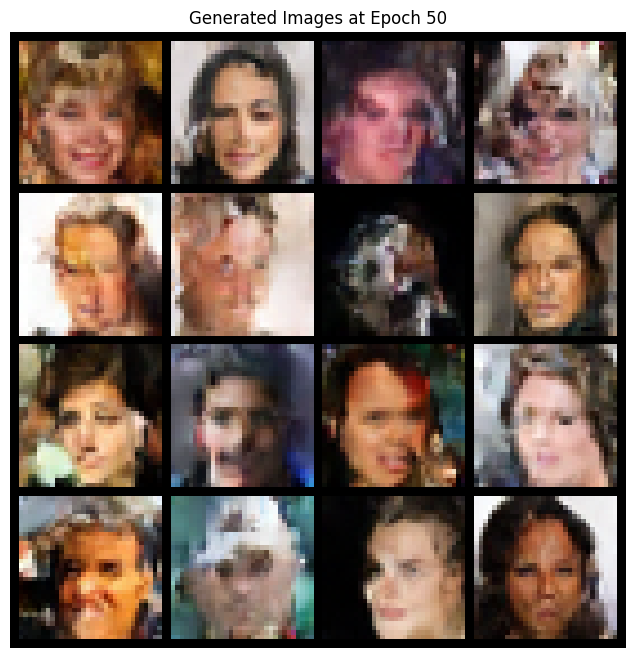

2025-06-22 11:31:16 - INFO - ------------------------------
2025-06-22 11:31:21 - INFO - Epoch: 51/60 | Batch: 0/318 | Loss (NLL): -9035.1104 | BPD: 3.7569
2025-06-22 11:33:43 - INFO - Epoch: 51/60 | Batch: 50/318 | Loss (NLL): -8995.8652 | BPD: 3.7753
2025-06-22 11:36:06 - INFO - Epoch: 51/60 | Batch: 100/318 | Loss (NLL): -8954.2930 | BPD: 3.7948
2025-06-22 11:38:28 - INFO - Epoch: 51/60 | Batch: 150/318 | Loss (NLL): -8966.7119 | BPD: 3.7890
2025-06-22 11:40:50 - INFO - Epoch: 51/60 | Batch: 200/318 | Loss (NLL): -9016.1152 | BPD: 3.7658
2025-06-22 11:43:12 - INFO - Epoch: 51/60 | Batch: 250/318 | Loss (NLL): -8946.0430 | BPD: 3.7987
2025-06-22 11:45:34 - INFO - Epoch: 51/60 | Batch: 300/318 | Loss (NLL): -8990.6904 | BPD: 3.7777
2025-06-22 11:46:21 - INFO - --- Epoch 51 Summary ---
2025-06-22 11:46:21 - INFO - Average Loss: -8960.1023 | Time: 905.17s
2025-06-22 11:46:21 - INFO - Generating sample images...


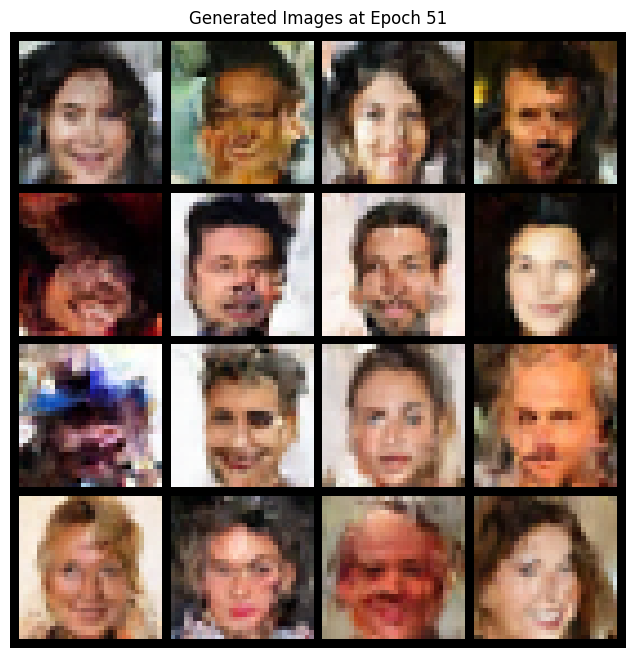

2025-06-22 11:46:22 - INFO - ------------------------------
2025-06-22 11:46:27 - INFO - Epoch: 52/60 | Batch: 0/318 | Loss (NLL): -8949.2012 | BPD: 3.7972
2025-06-22 11:48:49 - INFO - Epoch: 52/60 | Batch: 50/318 | Loss (NLL): -8975.0869 | BPD: 3.7851
2025-06-22 11:51:11 - INFO - Epoch: 52/60 | Batch: 100/318 | Loss (NLL): -8922.4277 | BPD: 3.8098
2025-06-22 11:53:36 - INFO - Epoch: 52/60 | Batch: 150/318 | Loss (NLL): -8866.6680 | BPD: 3.8360
2025-06-22 11:56:04 - INFO - Epoch: 52/60 | Batch: 200/318 | Loss (NLL): -8939.3711 | BPD: 3.8018
2025-06-22 11:58:27 - INFO - Epoch: 52/60 | Batch: 250/318 | Loss (NLL): -8884.7451 | BPD: 3.8275
2025-06-22 12:00:51 - INFO - Epoch: 52/60 | Batch: 300/318 | Loss (NLL): -8918.2002 | BPD: 3.8118
2025-06-22 12:01:40 - INFO - --- Epoch 52 Summary ---
2025-06-22 12:01:40 - INFO - Average Loss: -8955.0003 | Time: 918.54s
2025-06-22 12:01:40 - INFO - Generating sample images...


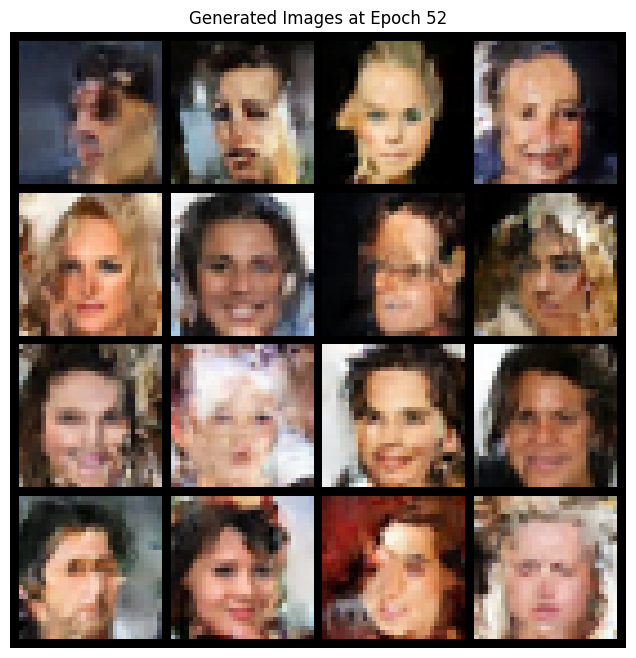

2025-06-22 12:01:41 - INFO - ------------------------------
2025-06-22 12:01:46 - INFO - Epoch: 53/60 | Batch: 0/318 | Loss (NLL): -8977.1045 | BPD: 3.7841
2025-06-22 12:04:11 - INFO - Epoch: 53/60 | Batch: 50/318 | Loss (NLL): -8972.9004 | BPD: 3.7861
2025-06-22 12:06:35 - INFO - Epoch: 53/60 | Batch: 100/318 | Loss (NLL): -8970.5215 | BPD: 3.7872
2025-06-22 12:08:56 - INFO - Epoch: 53/60 | Batch: 150/318 | Loss (NLL): -8960.7617 | BPD: 3.7918
2025-06-22 12:11:19 - INFO - Epoch: 53/60 | Batch: 200/318 | Loss (NLL): -9015.0693 | BPD: 3.7663
2025-06-22 12:13:44 - INFO - Epoch: 53/60 | Batch: 250/318 | Loss (NLL): -8940.8340 | BPD: 3.8011
2025-06-22 12:16:09 - INFO - Epoch: 53/60 | Batch: 300/318 | Loss (NLL): -8987.7461 | BPD: 3.7791
2025-06-22 12:16:57 - INFO - --- Epoch 53 Summary ---
2025-06-22 12:16:57 - INFO - Average Loss: -8972.9066 | Time: 916.14s
2025-06-22 12:16:57 - INFO - Generating sample images...


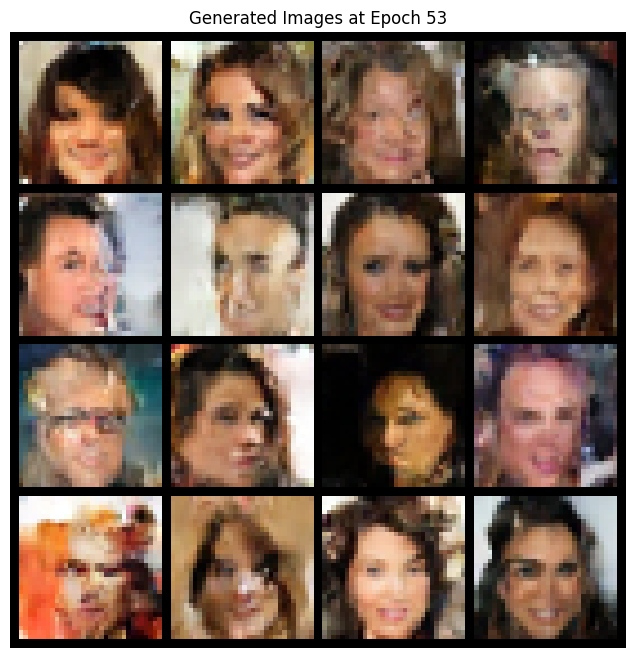

2025-06-22 12:16:58 - INFO - ------------------------------
2025-06-22 12:17:02 - INFO - Epoch: 54/60 | Batch: 0/318 | Loss (NLL): -8994.2139 | BPD: 3.7761
2025-06-22 12:19:24 - INFO - Epoch: 54/60 | Batch: 50/318 | Loss (NLL): -8982.3809 | BPD: 3.7816
2025-06-22 12:21:46 - INFO - Epoch: 54/60 | Batch: 100/318 | Loss (NLL): -8984.7373 | BPD: 3.7805
2025-06-22 12:24:09 - INFO - Epoch: 54/60 | Batch: 150/318 | Loss (NLL): -8923.1309 | BPD: 3.8095
2025-06-22 12:26:31 - INFO - Epoch: 54/60 | Batch: 200/318 | Loss (NLL): -8977.0645 | BPD: 3.7841
2025-06-22 12:28:54 - INFO - Epoch: 54/60 | Batch: 250/318 | Loss (NLL): -9031.2988 | BPD: 3.7587
2025-06-22 12:31:16 - INFO - Epoch: 54/60 | Batch: 300/318 | Loss (NLL): -8894.4688 | BPD: 3.8229
2025-06-22 12:32:04 - INFO - --- Epoch 54 Summary ---
2025-06-22 12:32:04 - INFO - Average Loss: -8970.2628 | Time: 906.89s
2025-06-22 12:32:04 - INFO - Generating sample images...


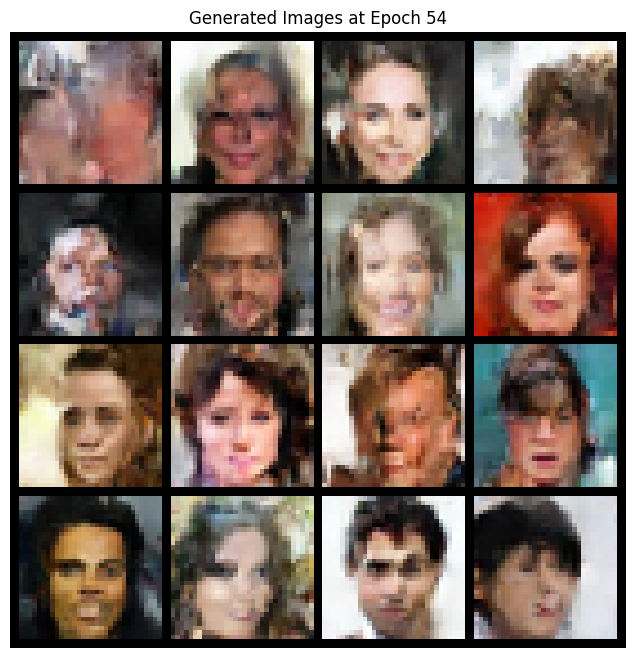

2025-06-22 12:32:05 - INFO - ------------------------------
2025-06-22 12:32:10 - INFO - Epoch: 55/60 | Batch: 0/318 | Loss (NLL): -8903.2656 | BPD: 3.8188
2025-06-22 12:34:32 - INFO - Epoch: 55/60 | Batch: 50/318 | Loss (NLL): -9070.5879 | BPD: 3.7402
2025-06-22 12:36:54 - INFO - Epoch: 55/60 | Batch: 100/318 | Loss (NLL): -8960.0547 | BPD: 3.7921
2025-06-22 12:39:17 - INFO - Epoch: 55/60 | Batch: 150/318 | Loss (NLL): -8976.2607 | BPD: 3.7845
2025-06-22 12:41:39 - INFO - Epoch: 55/60 | Batch: 200/318 | Loss (NLL): -8838.5117 | BPD: 3.8492
2025-06-22 12:44:00 - INFO - Epoch: 55/60 | Batch: 250/318 | Loss (NLL): -8940.3516 | BPD: 3.8014
2025-06-22 12:46:21 - INFO - Epoch: 55/60 | Batch: 300/318 | Loss (NLL): -9010.4990 | BPD: 3.7684
2025-06-22 12:47:09 - INFO - --- Epoch 55 Summary ---
2025-06-22 12:47:09 - INFO - Average Loss: -8983.5209 | Time: 904.45s
2025-06-22 12:47:09 - INFO - Generating sample images...


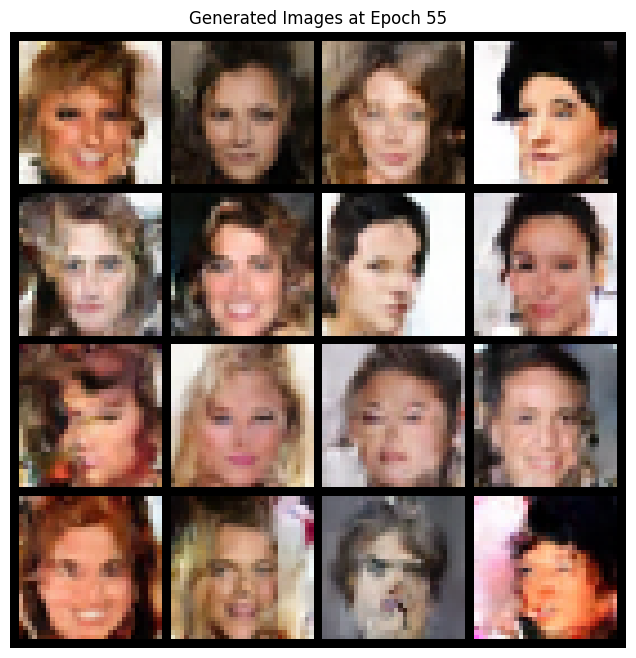

2025-06-22 12:47:10 - INFO - ------------------------------
2025-06-22 12:47:15 - INFO - Epoch: 56/60 | Batch: 0/318 | Loss (NLL): -8981.9268 | BPD: 3.7818
2025-06-22 12:49:34 - INFO - Epoch: 56/60 | Batch: 50/318 | Loss (NLL): -8969.0381 | BPD: 3.7879
2025-06-22 12:51:57 - INFO - Epoch: 56/60 | Batch: 100/318 | Loss (NLL): -8992.6094 | BPD: 3.7768
2025-06-22 12:54:19 - INFO - Epoch: 56/60 | Batch: 150/318 | Loss (NLL): -8991.4434 | BPD: 3.7774
2025-06-22 12:56:42 - INFO - Epoch: 56/60 | Batch: 200/318 | Loss (NLL): -9030.4551 | BPD: 3.7591
2025-06-22 12:59:05 - INFO - Epoch: 56/60 | Batch: 250/318 | Loss (NLL): -9010.1426 | BPD: 3.7686
2025-06-22 13:01:27 - INFO - Epoch: 56/60 | Batch: 300/318 | Loss (NLL): -9020.2949 | BPD: 3.7638
2025-06-22 13:02:16 - INFO - --- Epoch 56 Summary ---
2025-06-22 13:02:16 - INFO - Average Loss: -9004.2211 | Time: 905.86s
2025-06-22 13:02:16 - INFO - Generating sample images...


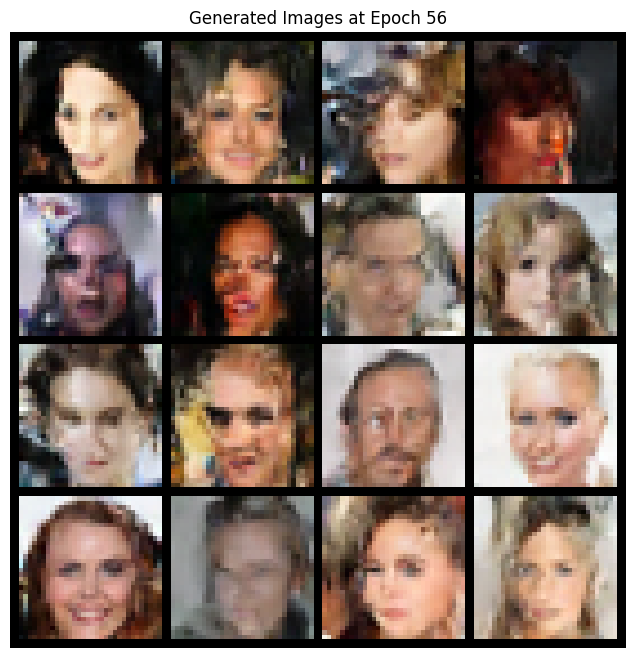

2025-06-22 13:02:16 - INFO - ------------------------------
2025-06-22 13:02:21 - INFO - Epoch: 57/60 | Batch: 0/318 | Loss (NLL): -9011.9932 | BPD: 3.7677
2025-06-22 13:04:43 - INFO - Epoch: 57/60 | Batch: 50/318 | Loss (NLL): -9004.3320 | BPD: 3.7713
2025-06-22 13:07:06 - INFO - Epoch: 57/60 | Batch: 100/318 | Loss (NLL): -8976.3281 | BPD: 3.7845
2025-06-22 13:09:28 - INFO - Epoch: 57/60 | Batch: 150/318 | Loss (NLL): -8960.7637 | BPD: 3.7918
2025-06-22 13:11:51 - INFO - Epoch: 57/60 | Batch: 200/318 | Loss (NLL): -9003.1035 | BPD: 3.7719
2025-06-22 13:14:14 - INFO - Epoch: 57/60 | Batch: 250/318 | Loss (NLL): -9009.4766 | BPD: 3.7689
2025-06-22 13:16:36 - INFO - Epoch: 57/60 | Batch: 300/318 | Loss (NLL): -9024.2812 | BPD: 3.7620
2025-06-22 13:17:24 - INFO - --- Epoch 57 Summary ---
2025-06-22 13:17:24 - INFO - Average Loss: -8995.8782 | Time: 907.48s
2025-06-22 13:17:24 - INFO - Generating sample images...


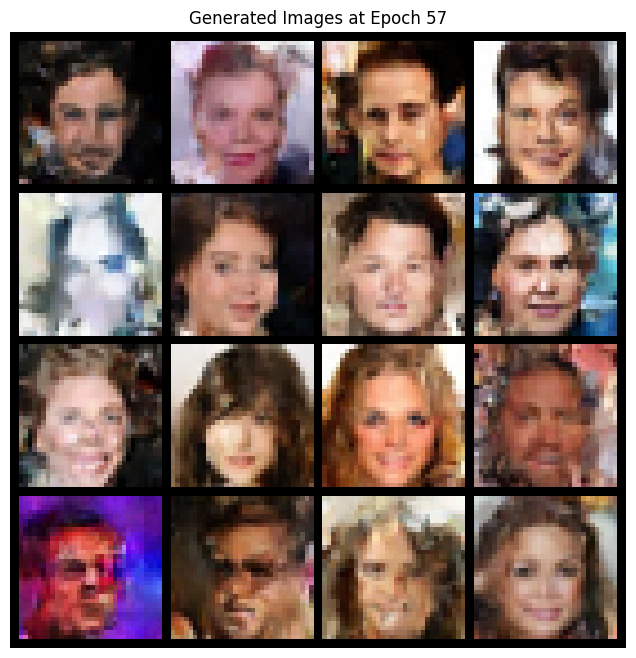

2025-06-22 13:17:24 - INFO - ------------------------------
2025-06-22 13:17:29 - INFO - Epoch: 58/60 | Batch: 0/318 | Loss (NLL): -9029.0762 | BPD: 3.7597
2025-06-22 13:19:52 - INFO - Epoch: 58/60 | Batch: 50/318 | Loss (NLL): -8972.1445 | BPD: 3.7864
2025-06-22 13:22:14 - INFO - Epoch: 58/60 | Batch: 100/318 | Loss (NLL): -9046.2559 | BPD: 3.7516
2025-06-22 13:24:36 - INFO - Epoch: 58/60 | Batch: 150/318 | Loss (NLL): -8932.6582 | BPD: 3.8050
2025-06-22 13:26:58 - INFO - Epoch: 58/60 | Batch: 200/318 | Loss (NLL): -9089.5996 | BPD: 3.7313
2025-06-22 13:29:21 - INFO - Epoch: 58/60 | Batch: 250/318 | Loss (NLL): -9007.0977 | BPD: 3.7700
2025-06-22 13:31:44 - INFO - Epoch: 58/60 | Batch: 300/318 | Loss (NLL): -8987.4287 | BPD: 3.7793
2025-06-22 13:32:32 - INFO - --- Epoch 58 Summary ---
2025-06-22 13:32:32 - INFO - Average Loss: -9005.8410 | Time: 907.35s
2025-06-22 13:32:32 - INFO - Generating sample images...


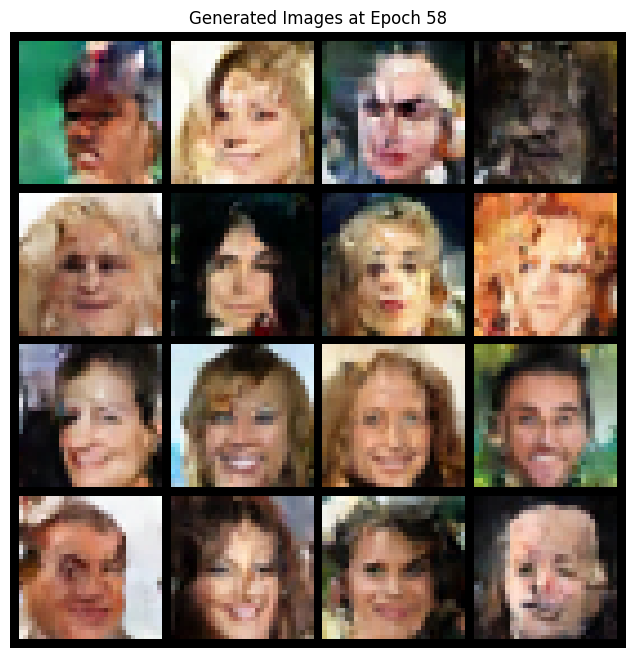

2025-06-22 13:32:32 - INFO - ------------------------------
2025-06-22 13:32:37 - INFO - Epoch: 59/60 | Batch: 0/318 | Loss (NLL): -9053.2676 | BPD: 3.7483
2025-06-22 13:35:00 - INFO - Epoch: 59/60 | Batch: 50/318 | Loss (NLL): -9008.2197 | BPD: 3.7695
2025-06-22 13:37:23 - INFO - Epoch: 59/60 | Batch: 100/318 | Loss (NLL): -9035.8418 | BPD: 3.7565
2025-06-22 13:39:47 - INFO - Epoch: 59/60 | Batch: 150/318 | Loss (NLL): -9029.9590 | BPD: 3.7593
2025-06-22 13:42:09 - INFO - Epoch: 59/60 | Batch: 200/318 | Loss (NLL): -8967.3047 | BPD: 3.7887
2025-06-22 13:44:32 - INFO - Epoch: 59/60 | Batch: 250/318 | Loss (NLL): -9065.9648 | BPD: 3.7424
2025-06-22 13:46:53 - INFO - Epoch: 59/60 | Batch: 300/318 | Loss (NLL): -9080.6699 | BPD: 3.7355
2025-06-22 13:47:41 - INFO - --- Epoch 59 Summary ---
2025-06-22 13:47:41 - INFO - Average Loss: -9016.5575 | Time: 909.04s
2025-06-22 13:47:41 - INFO - Generating sample images...


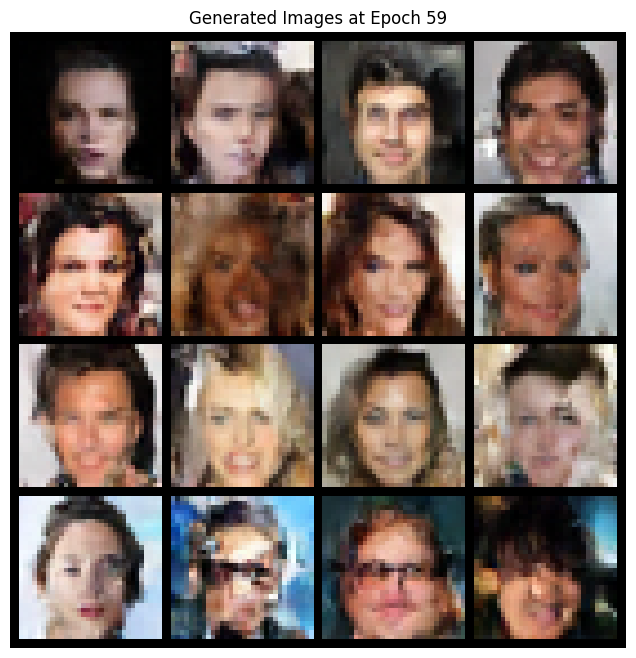

2025-06-22 13:47:42 - INFO - ------------------------------
2025-06-22 13:47:46 - INFO - Epoch: 60/60 | Batch: 0/318 | Loss (NLL): -9027.0840 | BPD: 3.7606
2025-06-22 13:50:09 - INFO - Epoch: 60/60 | Batch: 50/318 | Loss (NLL): -8960.5664 | BPD: 3.7919
2025-06-22 13:52:31 - INFO - Epoch: 60/60 | Batch: 100/318 | Loss (NLL): -9047.7031 | BPD: 3.7510
2025-06-22 13:54:54 - INFO - Epoch: 60/60 | Batch: 150/318 | Loss (NLL): -9081.6992 | BPD: 3.7350
2025-06-22 13:57:17 - INFO - Epoch: 60/60 | Batch: 200/318 | Loss (NLL): -8977.0967 | BPD: 3.7841
2025-06-22 13:59:39 - INFO - Epoch: 60/60 | Batch: 250/318 | Loss (NLL): -9062.1318 | BPD: 3.7442
2025-06-22 14:02:02 - INFO - Epoch: 60/60 | Batch: 300/318 | Loss (NLL): -9016.2715 | BPD: 3.7657
2025-06-22 14:02:51 - INFO - --- Epoch 60 Summary ---
2025-06-22 14:02:51 - INFO - Average Loss: -9027.4992 | Time: 909.06s
2025-06-22 14:02:51 - INFO - Generating sample images...


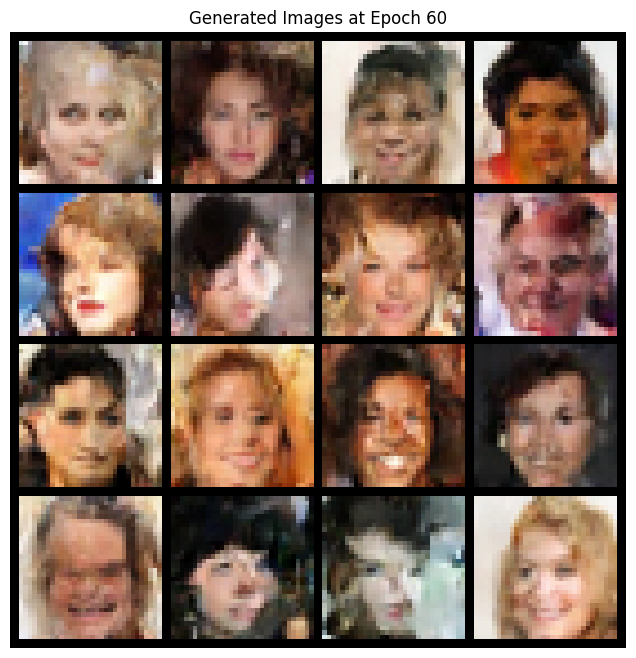

2025-06-22 14:02:51 - INFO - ------------------------------


In [ ]:
IMAGE_SIZE = 32
NUM_CHANNELS = 3
BATCH_SIZE = batch_size
LEARNING_RATE = 1e-3
NUM_EPOCHS = 60
prior_str = "gaussian"
prior = PriorDistribution(dist_type=prior_str)

logger = setup_logger()
optimizer = torch.optim.AdamW(flow.parameters(), lr=LEARNING_RATE, weight_decay=5e-5)

try:
    train_rg_flow(
        model=flow,
        prior=prior,
        train_loader=train_loader,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=DEVICE,
        image_dims=(NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE),
        logger=logger,
        num_images_to_generate=16
    )
except Exception as e:
    logger.error("An error occurred during training!", exc_info=True)

In [ ]:
from datetime import datetime

# Create a timestamp for the filename
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
MODEL_WEIGHTS_PATH = f"rg_flow_weights_{timestamp}_{NUM_EPOCHS}_{prior_str}.pth"

print(f"Saving model weights to {MODEL_WEIGHTS_PATH}...")

# Use model.state_dict() to get the dictionary of weights
torch.save(flow.state_dict(), MODEL_WEIGHTS_PATH)

print("Model weights saved successfully.")
files.download(MODEL_WEIGHTS_PATH)

Saving model weights to rg_flow_weights_2025-06-22_14-04-35_60_gaussian.pth...
Model weights saved successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
# Download the generated images directory
!zip -r generated_images.zip generated_images
files.download('generated_images.zip')
# Download the model weights file

  adding: generated_images/ (stored 0%)
  adding: generated_images/epoch_042.png (deflated 9%)
  adding: generated_images/epoch_008.png (deflated 9%)
  adding: generated_images/epoch_058.png (deflated 9%)
  adding: generated_images/epoch_048.png (deflated 9%)
  adding: generated_images/epoch_019.png (deflated 9%)
  adding: generated_images/epoch_031.png (deflated 9%)
  adding: generated_images/epoch_003.png (deflated 9%)
  adding: generated_images/epoch_036.png (deflated 9%)
  adding: generated_images/epoch_057.png (deflated 9%)
  adding: generated_images/epoch_046.png (deflated 9%)
  adding: generated_images/epoch_015.png (deflated 9%)
  adding: generated_images/epoch_060.png (deflated 9%)
  adding: generated_images/epoch_035.png (deflated 9%)
  adding: generated_images/epoch_052.png (deflated 9%)
  adding: generated_images/epoch_032.png (deflated 9%)
  adding: generated_images/epoch_005.png (deflated 9%)
  adding: generated_images/epoch_002.png (deflated 9%)
  adding: generated_image

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# prompt: Save the optimizer

# Define the path for saving the optimizer state
optimizer_path = f"rg_flow_optimizer_{timestamp}_{NUM_EPOCHS}_{prior_str}.pth"

print(f"Saving optimizer state to {optimizer_path}...")

# Save the state_dict of the optimizer
torch.save(optimizer.state_dict(), optimizer_path)

print("Optimizer state saved successfully.")

# Download the optimizer state file
files.download(optimizer_path)

Saving optimizer state to rg_flow_optimizer_2025-06-22_14-08-53_60_gaussian.pth...
Optimizer state saved successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# prompt: Save the logs, images, weights and optimizer to drive

# Define the base directory for saving to Drive
drive_save_dir = "/content/drive/MyDrive/RG_Flow_Training_Runs"
os.makedirs(drive_save_dir, exist_ok=True)
print(f"Saving artifacts to: {drive_save_dir}")

# Define paths for saving specific artifacts within the Drive directory
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
run_dir = os.path.join(drive_save_dir, f"run_{timestamp}")
os.makedirs(run_dir, exist_ok=True)
print(f"Created run directory: {run_dir}")

import glob # Import the glob module

# Save Logs
log_file_pattern = f"training_run_*.log"
# Find the latest log file created by setup_logger
list_of_files = glob.glob(log_file_pattern)
if list_of_files:
    latest_log_file = max(list_of_files, key=os.path.getctime)
    drive_log_path = os.path.join(run_dir, os.path.basename(latest_log_file))
    print(f"Saving log file: {latest_log_file} to {drive_log_path}")
    !cp "{latest_log_file}" "{drive_log_path}"
else:
    print("No log files found to save.")


# Save Generated Images
generated_images_dir = "generated_images"
if os.path.exists(generated_images_dir):
    drive_images_path = os.path.join(run_dir, generated_images_dir)
    print(f"Saving generated images directory: {generated_images_dir} to {drive_images_path}")
    # Use rsync or similar for directories to handle potential large number of files
    !rsync -avz "{generated_images_dir}/" "{drive_images_path}/"
else:
    print(f"Generated images directory not found: {generated_images_dir}")

# Save Model Weights
# The MODEL_WEIGHTS_PATH is already defined in the preceding code before saving
if os.path.exists(MODEL_WEIGHTS_PATH):
    drive_weights_path = os.path.join(run_dir, os.path.basename(MODEL_WEIGHTS_PATH))
    print(f"Saving model weights: {MODEL_WEIGHTS_PATH} to {drive_weights_path}")
    !cp "{MODEL_WEIGHTS_PATH}" "{drive_weights_path}"
else:
    print(f"Model weights file not found: {MODEL_WEIGHTS_PATH}")

# Save Optimizer State
# The optimizer_path is already defined in the preceding code before saving
if os.path.exists(optimizer_path):
    drive_optimizer_path = os.path.join(run_dir, os.path.basename(optimizer_path))
    print(f"Saving optimizer state: {optimizer_path} to {drive_optimizer_path}")
    !cp "{optimizer_path}" "{drive_optimizer_path}"
else:
    print(f"Optimizer state file not found: {optimizer_path}")

print("\nAll specified artifacts saved to Google Drive.")

Saving artifacts to: /content/drive/MyDrive/RG_Flow_Training_Runs
Created run directory: /content/drive/MyDrive/RG_Flow_Training_Runs/run_2025-06-22_14-08-53
Saving log file: training_run_2025-06-21_22-56-37.log to /content/drive/MyDrive/RG_Flow_Training_Runs/run_2025-06-22_14-08-53/training_run_2025-06-21_22-56-37.log
Saving generated images directory: generated_images to /content/drive/MyDrive/RG_Flow_Training_Runs/run_2025-06-22_14-08-53/generated_images
sending incremental file list
created directory /content/drive/MyDrive/RG_Flow_Training_Runs/run_2025-06-22_14-08-53/generated_images
./
epoch_001.png
epoch_002.png
epoch_003.png
epoch_004.png
epoch_005.png
epoch_006.png
epoch_007.png
epoch_008.png
epoch_009.png
epoch_010.png
epoch_011.png
epoch_012.png
epoch_013.png
epoch_014.png
epoch_015.png
epoch_016.png
epoch_017.png
epoch_018.png
epoch_019.png
epoch_020.png
epoch_021.png
epoch_022.png
epoch_023.png
epoch_024.png
epoch_025.png
epoch_026.png
epoch_027.png
epoch_028.png
epoch_029